```
This notebook sets up and runs a set of benchmarks to compare
different numerical discretizations of the SWEs

Copyright (C) 2016  SINTEF ICT

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Spin-up model

In this notebook, we prototype and experiment with spin-up models in order to search for good initial conditions for ensemble simulations.

## Set environment

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc
from scipy.special import lambertw
from importlib import reload

import pycuda.driver as cuda

import os
import sys

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))

#Set large figure sizes
#rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

#Import our simulator
from SWESimulators import CDKLM16, PlotHelper, Common, IPythonMagic, DoubleJetCase

from SWESimulators import BathymetryAndICs as BC
from SWESimulators import OceanStateNoise, shallowWaterGPUhelpers



In [2]:
%cuda_context_handler gpu_ctx

# Finding the natural update values in the IEWPF test case


In [3]:
waterDepth = 230
def sim_animation(sim, T, plot_dt, crossection=False, spinUp=False, snapshot=False):
    
    #Helper function which simulates and plots the solution
    if spinUp:
        t = sim.step(20*plot_dt*dt)
    
    eta1, hu1, hv1 = sim.download(interior_domain_only=True)
    print("sim.download in sim_animator - eta1.shape: ", eta1.shape)
    
    dx_km = sim.dx/1000
    dy_km = sim.dy/1000
    
    # Missing variables:
    eta_max = np.max(np.abs(eta1))
    hu_max  = max(np.max(np.abs(hu1)), np.max(np.abs(hv1)))
    h_mean = 230
    
    #Create figure and plot initial conditions
    fig = plt.figure(figsize=(12, 12), constrained_layout=True)
    domain_extent = [0, eta1.shape[1]*dx_km, 0, eta1.shape[0]*dy_km]
    y_axis_eta = np.linspace(0.5*dy_km, (sim.ny+0.5)*dy_km, eta1.shape[0])
    y_axis_hu  = np.linspace(0.5*dy_km, (sim.ny+0.5)*dy_km, hu1.shape[0])
    y_axis_hv  = np.linspace(0.5*dy_km, (sim.ny+0.5)*dy_km, hv1.shape[0])
    mid_cell_x = int(eta1.shape[1]/2)
    pert_cell_x = int(eta1.shape[1]/5)
    
    gs = fig.add_gridspec(4,5)
    
    ax_eta = fig.add_subplot(gs[0,0:-2])
    sp_eta = ax_eta.imshow(eta1, interpolation="spline36", origin='bottom', vmin=-eta_max, vmax=eta_max, extent=domain_extent)
    solid_eta  = ax_eta.plot([mid_cell_x*dx_km, mid_cell_x*dx_km],   [0, eta1.shape[0]*dy_km], 'C9-')
    dotted_eta = ax_eta.plot([pert_cell_x*dx_km, pert_cell_x*dx_km], [0, eta1.shape[0]*dy_km], 'C3-.')
    ax_eta.set_title('$\eta$')
    
    drifters = ax_eta.scatter(x=None, y=None, color='C6')
    if sim.hasDrifters:
        drifters.set_offsets(sim.drifters.getDrifterPositions()/1000)
    
    ax_u = fig.add_subplot(gs[1,0:-2])
    sp_u = ax_u.imshow(hu1, interpolation="spline36", origin='bottom', vmin=-hu_max, vmax=hu_max, extent=domain_extent)
    solid_u  = ax_u.plot([mid_cell_x*dx_km, mid_cell_x*dx_km],   [0, eta1.shape[0]*dy_km], 'C9-')
    dotted_u = ax_u.plot([pert_cell_x*dx_km, pert_cell_x*dx_km], [0, eta1.shape[0]*dy_km], 'C3-.')
    ax_u.set_title('$hu$')
   
    ax_v = fig.add_subplot(gs[2,0:-2])
    sp_v = ax_v.imshow(hv1, interpolation="spline36", origin='bottom', vmin=-hu_max, vmax=hu_max, extent=domain_extent)
    solid_v  = ax_v.plot([mid_cell_x*dx_km, mid_cell_x*dx_km],   [0, eta1.shape[0]*dy_km], 'C9-')
    dotted_v = ax_v.plot([pert_cell_x*dx_km, pert_cell_x*dx_km], [0, eta1.shape[0]*dy_km], 'C3-.')
    ax_v.set_title('$hv$')
   
    if crossection:
        ax_eta_cs = fig.add_subplot(gs[0,-2:])
        cs_eta_init, = ax_eta_cs.plot(y_axis_eta, eta1[:, mid_cell_x], 'C1--')
        cs_eta,      = ax_eta_cs.plot(y_axis_eta, eta1[:, mid_cell_x], 'C9-' )
        cs_eta_pert, = ax_eta_cs.plot(y_axis_eta, eta1[:, pert_cell_x], 'C3-.')
        ax_eta_cs.set_ylim(-eta_max*1.3, eta_max*1.3)
        ax_eta_cs.grid()
        
        ax_hu_cs = fig.add_subplot(gs[1,-2:])
        cs_hu_init, = ax_hu_cs.plot(y_axis_hu, hu1[:, mid_cell_x], 'C1--')
        cs_hu,      = ax_hu_cs.plot(y_axis_hu, hu1[:, mid_cell_x], 'C9-' )
        cs_hu_pert, = ax_hu_cs.plot(y_axis_hu, hu1[:, pert_cell_x], 'C3-.')
        ax_hu_cs.set_ylim(-hu_max, hu_max)
        ax_hu_cs.grid()
        
        ax_hv_cs = fig.add_subplot(gs[2,-2:])
        cs_hv_init, = ax_hv_cs.plot(y_axis_hv, hv1[:, mid_cell_x], 'C1--')
        cs_hv,      = ax_hv_cs.plot(y_axis_hv, hv1[:, mid_cell_x], 'C9-' )
        cs_hv_pert, = ax_hv_cs.plot(y_axis_hv, hv1[:, pert_cell_x], 'C3-.')
        ax_hv_cs.set_ylim(-hu_max, hu_max)
        ax_hv_cs.grid()
    
    ax_vort = fig.add_subplot(gs[3,0:-2])
    gen_vort = shallowWaterGPUhelpers.genColors(eta1, hu1/h_mean, hv1/h_mean, 
                                                        cmap=plt.cm.viridis, vmax=3, vmin=-3)
    sp_vort = ax_vort.imshow(gen_vort, interpolation="spline36", origin='bottom', 
                            vmin=-hu_max, vmax=hu_max, extent=domain_extent)
    ax_vort.set_title('Vorticity')
    
    
    fig.suptitle("Time = {:04.0f} s ({:s})".format(sim.t, sim.__class__.__name__), fontsize=18)
        
    if snapshot:
        return fig
    
    def animate(i):
        if (i>0):
            t = sim.step(plot_dt*dt)
        else:
            t = sim.t
        eta1, hu1, hv1 = sim.download(interior_domain_only=True)
        
        #Update plots
        fig.sca(ax_eta)
        sp_eta.set_data(eta1)
        
        if sim.hasDrifters:
            drifters.set_offsets(sim.drifters.getDrifterPositions()/1000)
        
        fig.sca(ax_u)
        sp_u.set_data(hu1)
        
        fig.sca(ax_v)
        sp_v.set_data(hv1)
        
        fig.sca(ax_vort)
        gen_vort = shallowWaterGPUhelpers.genColors(eta1, hu1/h_mean, hv1/h_mean, 
                                                            cmap=plt.cm.viridis, vmax=3, vmin=-3)
        sp_vort.set_data(gen_vort)
        
        if crossection:
            cs_eta.set_data(y_axis_eta, eta1[:, mid_cell_x])
            cs_hu.set_data(y_axis_hu,    hu1[:, mid_cell_x])
            cs_hv.set_data(y_axis_hv,    hv1[:, mid_cell_x])
            cs_eta_pert.set_data(y_axis_eta, eta1[:, pert_cell_x])
            cs_hu_pert.set_data(y_axis_hu,    hu1[:, pert_cell_x])
            cs_hv_pert.set_data(y_axis_hv,    hv1[:, pert_cell_x])
        
        fig.suptitle("Time = {:04.0f} s ({:s})".format(t, sim.__class__.__name__), fontsize=18)
        print("."+str(i)+".", end='')

    #Matplotlib for creating an animation
    anim = animation.FuncAnimation(fig, animate, range(T), interval=100)
    plt.close(fig)
    return anim

In [4]:
def getEnergy(sim):
    eta, hu, hv = sim.download(interior_domain_only=True)
    w = eta + waterDepth
    u = hu/w
    v = hv/w
    kinetic_energy = np.sum(u*u + v*v)
    
    w = np.sqrt(sim.g*w)

    # using eta_tmp buffer for {u|v} +- sqrt(gw)
    max_u, max_v = 0.0, 0.0
    max_u = max(max_u, np.max(np.abs(u + w)))
    max_u = max(max_u, np.max(np.abs(u - w)))
    max_v = max(max_v, np.max(np.abs(v + w)))
    max_v = max(max_v, np.max(np.abs(v - w)))

    max_dt = 0.25*min(sim.dx/max_u, sim.dy/max_v)
    return kinetic_energy, max_dt, np.max(np.abs(eta))

def step(i, sim):
    t = sim.step(100*sim.dt)
    sim_time[i] = t
    energy[i], max_dt[i], abs_max_eta[i] = getEnergy(sim)
    sim.dt = 0.8*max_dt[i]
    if i % 10 == 0:
        print( "step at i = " + str(i))
    return t


# Steady state

step at i = 10
step at i = 20
step at i = 30
step at i = 40
step at i = 50
step at i = 60
step at i = 70
step at i = 80
step at i = 90
step at i = 100
step at i = 110
step at i = 120
step at i = 130
step at i = 140
step at i = 150
step at i = 160
step at i = 170
step at i = 180
step at i = 190
step at i = 200
step at i = 210
step at i = 220
step at i = 230
step at i = 240
step at i = 250
step at i = 260
step at i = 270
step at i = 280
step at i = 290
step at i = 300
step at i = 310
step at i = 320
step at i = 330
step at i = 340
step at i = 350
step at i = 360
step at i = 370
step at i = 380
step at i = 390
step at i = 400
step at i = 410
step at i = 420
step at i = 430
step at i = 440
step at i = 450
step at i = 460
step at i = 470
step at i = 480
step at i = 490
step at i = 500
step at i = 510
step at i = 520
step at i = 530
step at i = 540
step at i = 550
step at i = 560
step at i = 570
step at i = 580
step at i = 590
step at i = 600
step at i = 610
step at i = 620
step at i = 630
s

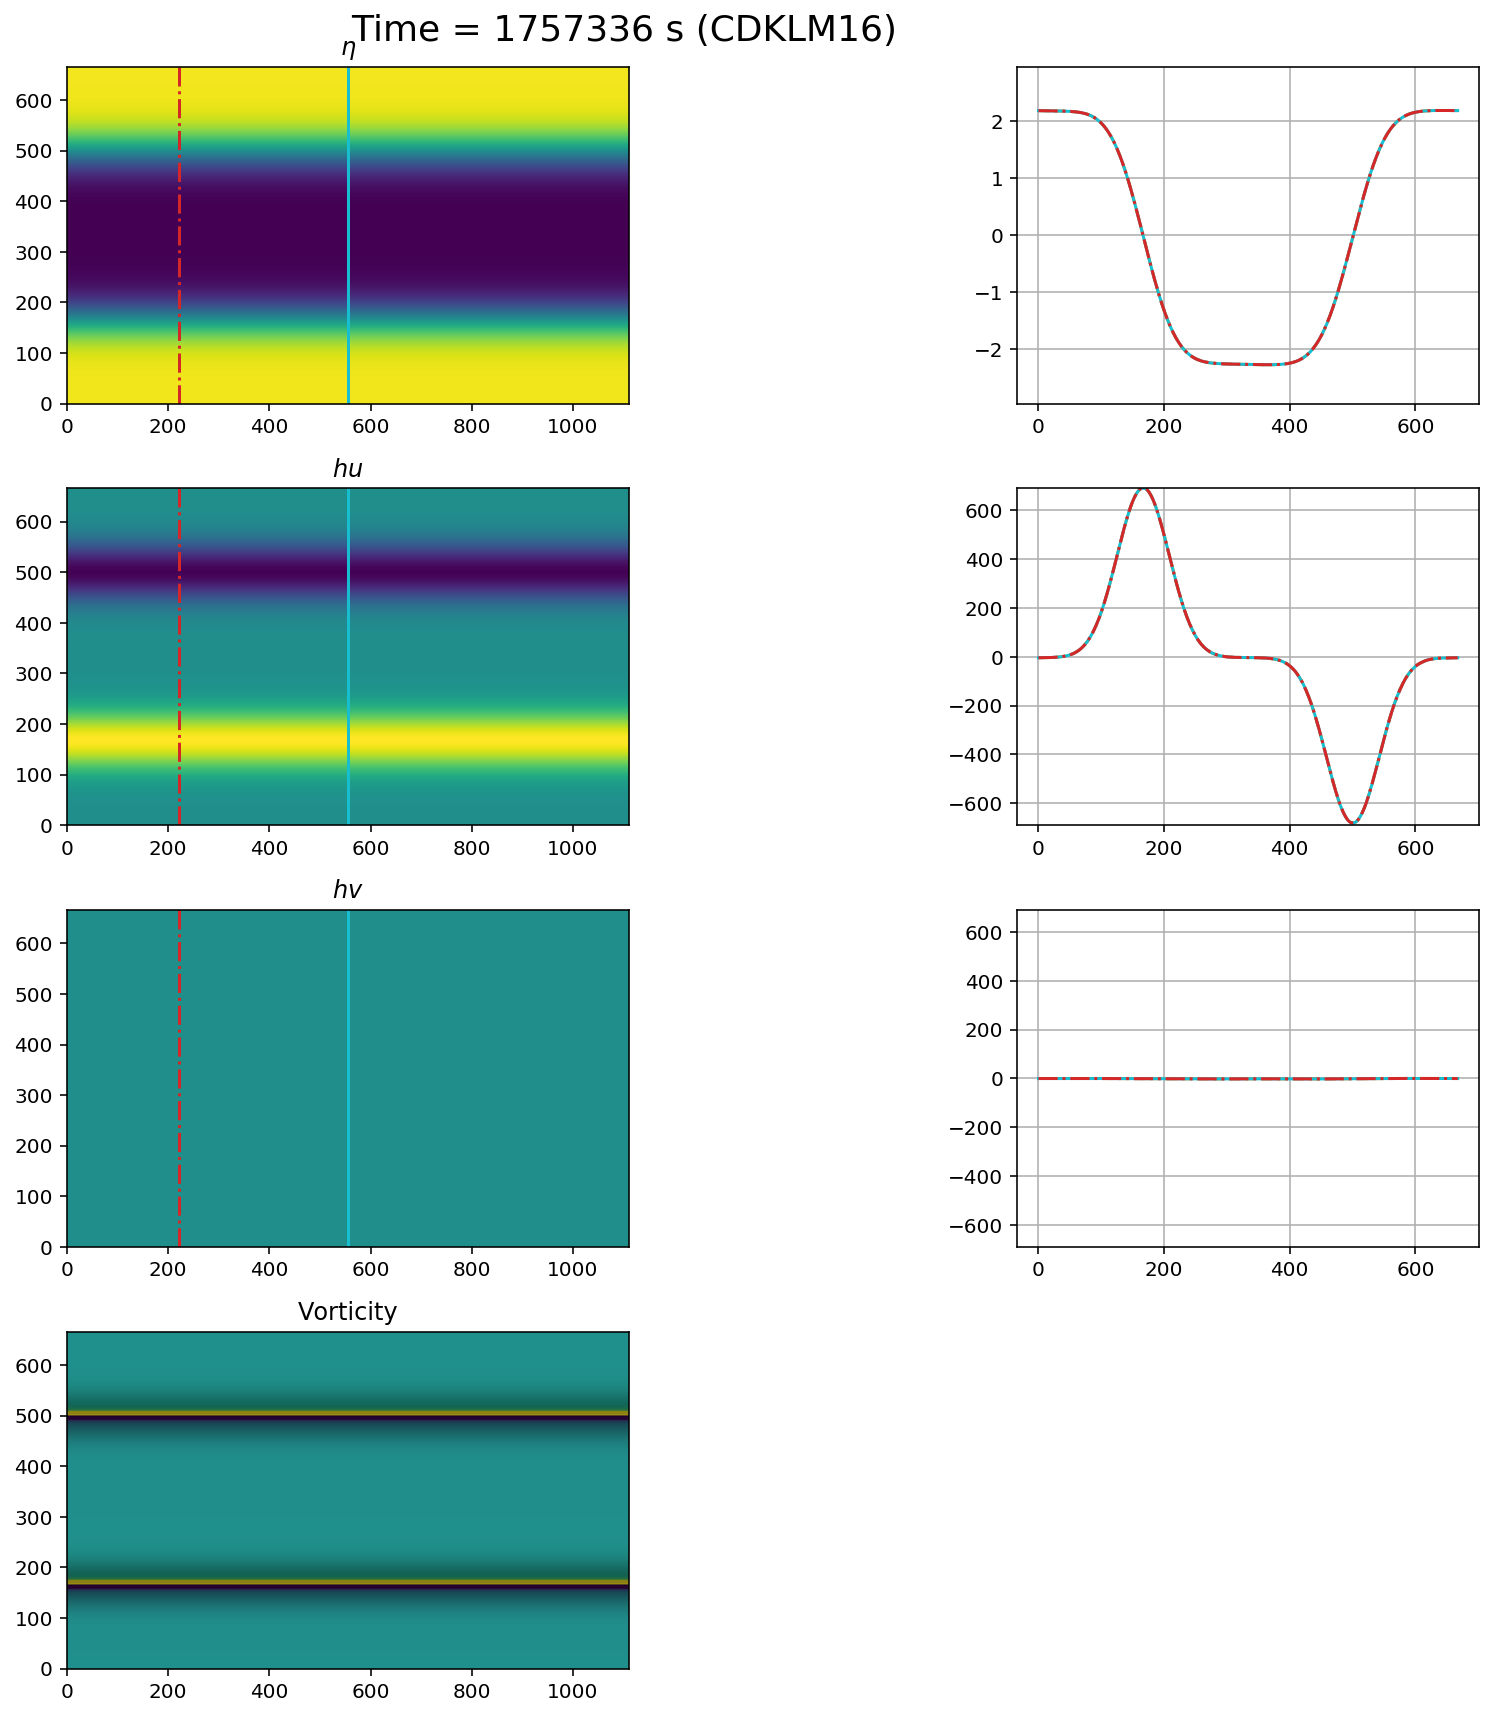

In [5]:
steadystate_doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx,
                                                        model_error=False)

steadystate_args, steadystate_init = steadystate_doubleJetCase.getInitConditions()
steadystate_CDKLM = CDKLM16.CDKLM16(**steadystate_args, **steadystate_init)

spin_up_timesteps = 2000
energy = np.zeros(spin_up_timesteps)
max_dt = np.zeros(spin_up_timesteps)
sim_time = np.zeros(spin_up_timesteps)
abs_max_eta = np.zeros(spin_up_timesteps)
energy[0], max_dt[0], abs_max_eta[0] = getEnergy(steadystate_CDKLM)
sim_time[0] = 0.0

for i in range(1,spin_up_timesteps):
    step(i, steadystate_CDKLM)

fig = sim_animation(steadystate_CDKLM, None, None, crossection=True, snapshot=True)


max dt:  10.990006446838379


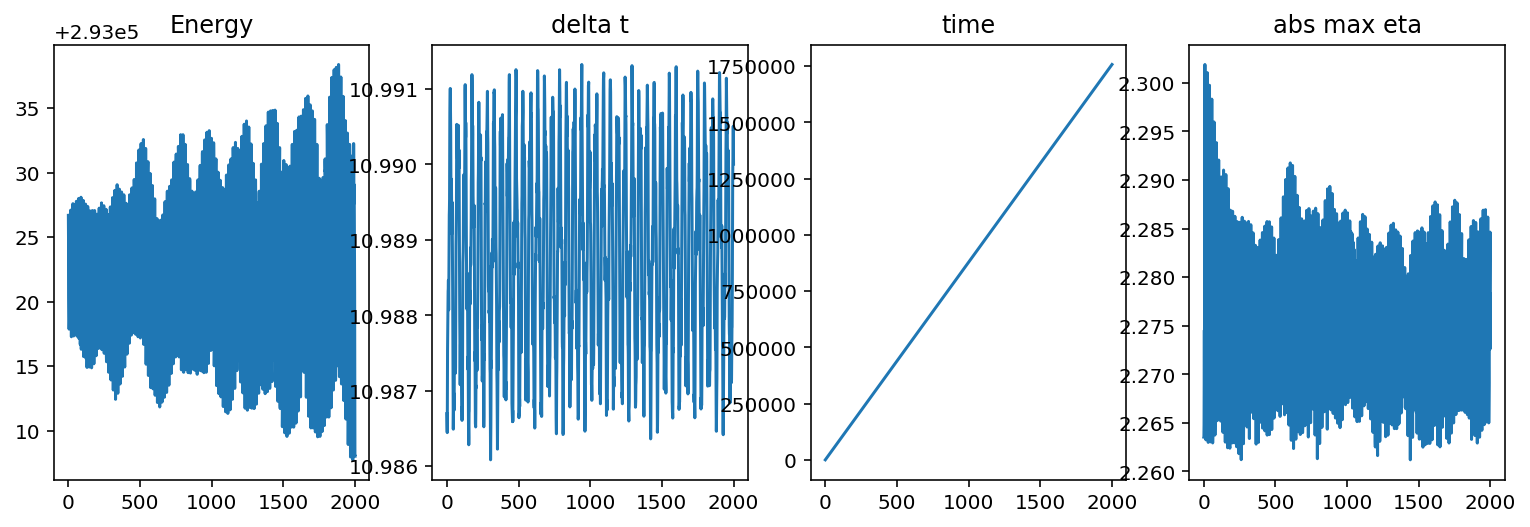

In [7]:

timesteps_axis = np.linspace(0, spin_up_timesteps, num=spin_up_timesteps)

fig = plt.figure(figsize=(13,4))
plt.subplot(1,4,1)
plt.plot(timesteps_axis, energy)
plt.title('Energy')
plt.subplot(1,4,2)
plt.plot(timesteps_axis, max_dt)
plt.title('delta t')
plt.subplot(1,4,3)
plt.plot(timesteps_axis, sim_time)
plt.title('time')
plt.subplot(1,4,4)
plt.plot(timesteps_axis, abs_max_eta)
plt.title("abs max eta")

print ("max dt: ", getEnergy(steadystate_CDKLM)[1])

#eta, hu, hv = sim.download(interior_domain_only=True)
#fig = plt.figure()
#plotter = PlotHelper.PlotHelper(fig, x_coords, y_coords, radius, eta, hu, hv, interpolation_type="none")
#plt.suptitle('Time: ' + str(sim_time[-1]/(60*60)) + " hours")

## The most promising test prior to running this notebook:

step at i = 10
step at i = 20
step at i = 30
step at i = 40
step at i = 50
step at i = 60
step at i = 70
step at i = 80
step at i = 90
step at i = 100
step at i = 110
step at i = 120
step at i = 130
step at i = 140
step at i = 150
step at i = 160
step at i = 170
step at i = 180
step at i = 190
step at i = 200
step at i = 210
step at i = 220
step at i = 230
step at i = 240
step at i = 250
step at i = 260
step at i = 270
step at i = 280
step at i = 290
step at i = 300
step at i = 310
step at i = 320
step at i = 330
step at i = 340
step at i = 350
step at i = 360
step at i = 370
step at i = 380
step at i = 390
step at i = 400
step at i = 410
step at i = 420
step at i = 430
step at i = 440
step at i = 450
step at i = 460
step at i = 470
step at i = 480
step at i = 490
step at i = 500
step at i = 510
step at i = 520
step at i = 530
step at i = 540
step at i = 550
step at i = 560
step at i = 570
step at i = 580
step at i = 590
step at i = 600
step at i = 610
step at i = 620
step at i = 630
s

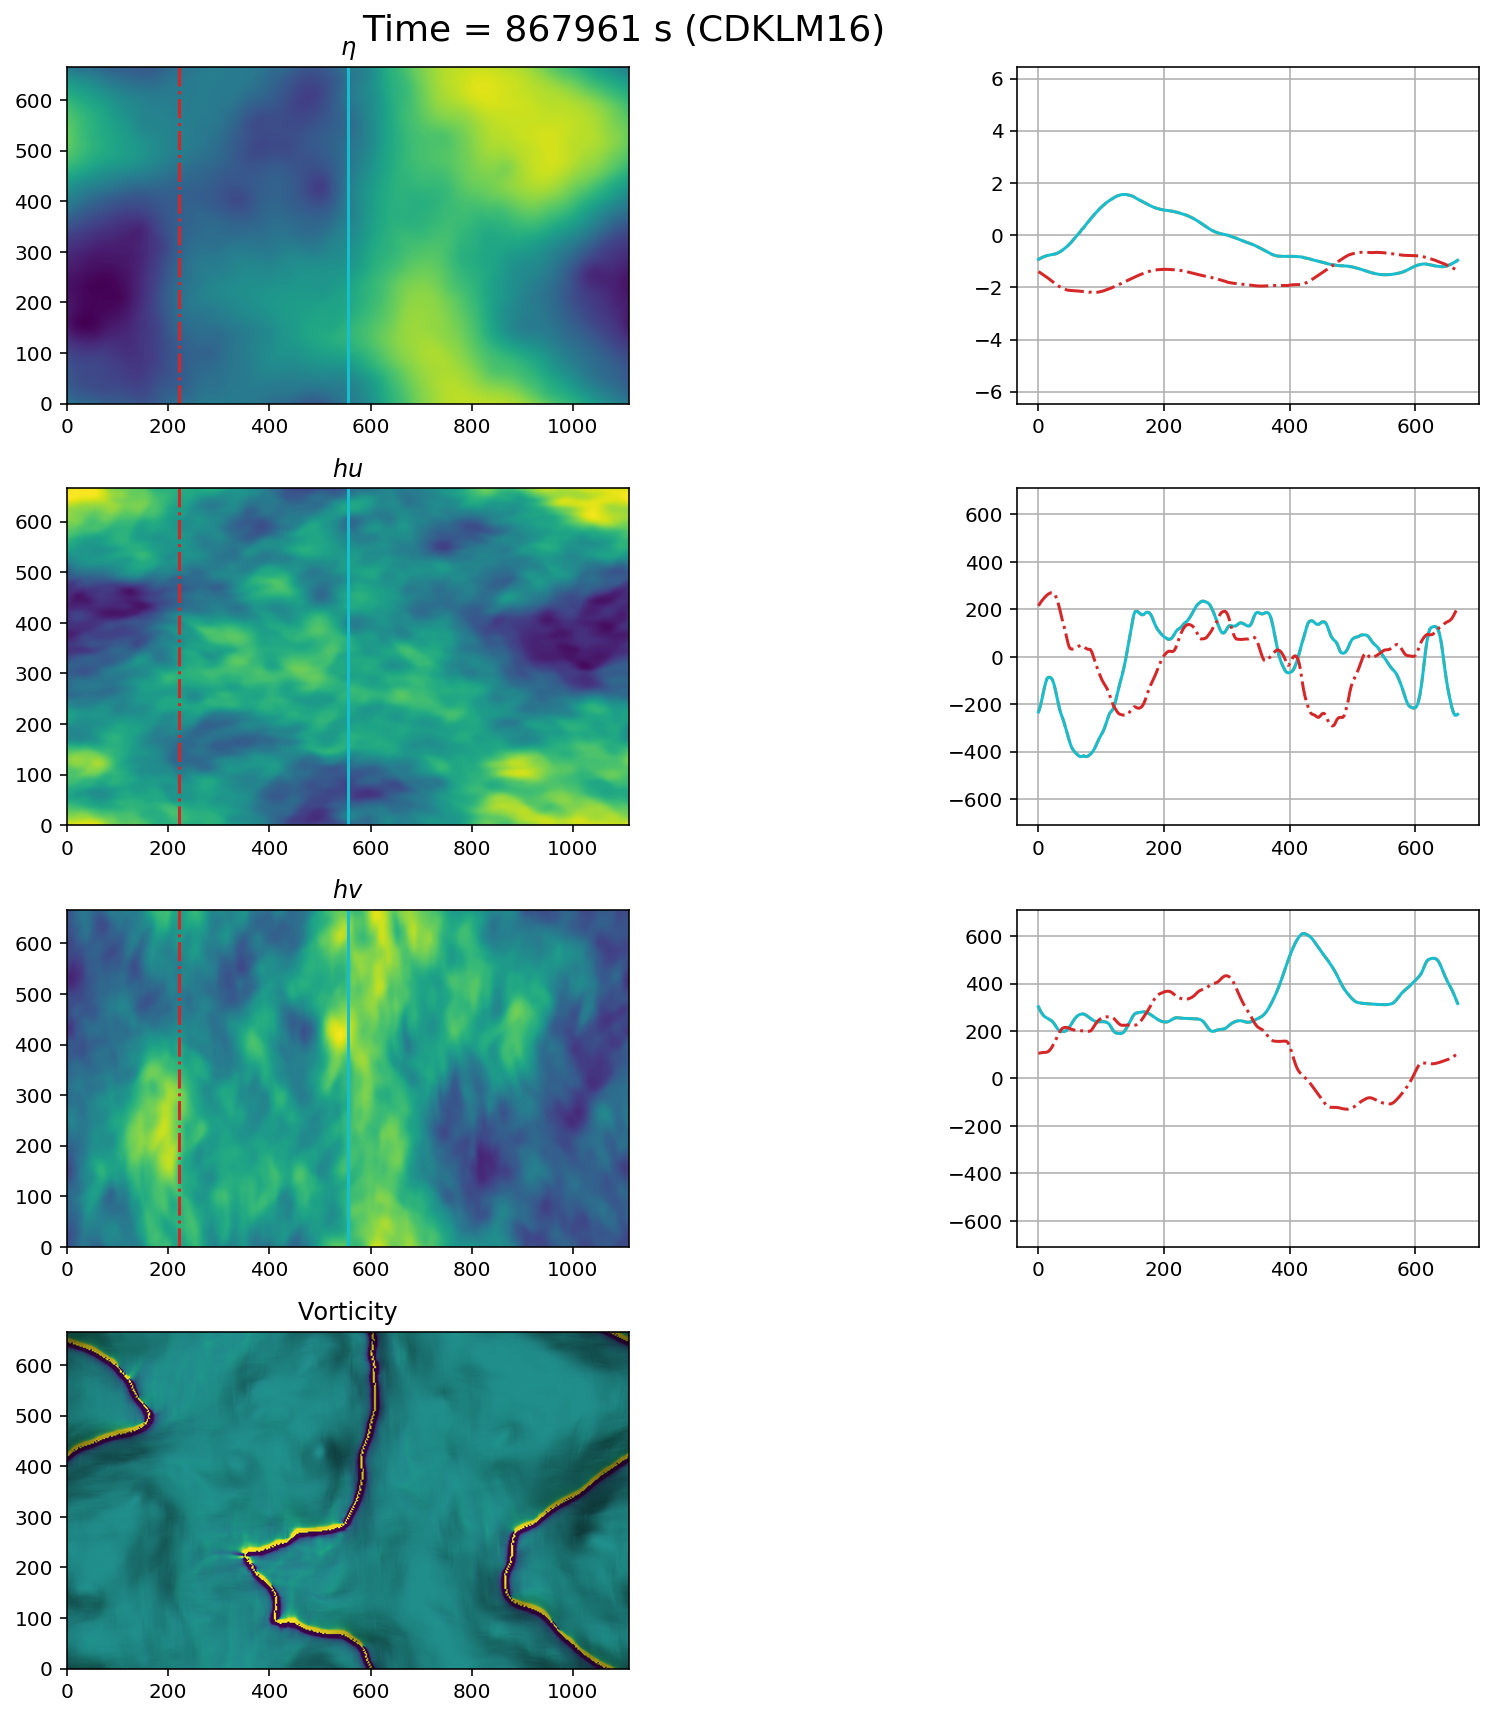

In [10]:
unpert_doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx,  
                                                   model_error=True)

unpert_args, unpert_init = unpert_doubleJetCase.getInitConditions()
unpert_CDKLM = CDKLM16.CDKLM16(**unpert_args, **unpert_init)
spin_up_timesteps = 1000
energy = np.zeros(spin_up_timesteps)
max_dt = np.zeros(spin_up_timesteps)
sim_time = np.zeros(spin_up_timesteps)
abs_max_eta = np.zeros(spin_up_timesteps)
energy[0], max_dt[0], abs_max_eta[0] = getEnergy(unpert_CDKLM)
sim_time[0] = 0.0

for i in range(1,spin_up_timesteps):
    step(i, unpert_CDKLM)

fig = sim_animation(unpert_CDKLM, None, None, crossection=True, snapshot=True)


max dt:  10.943603515625


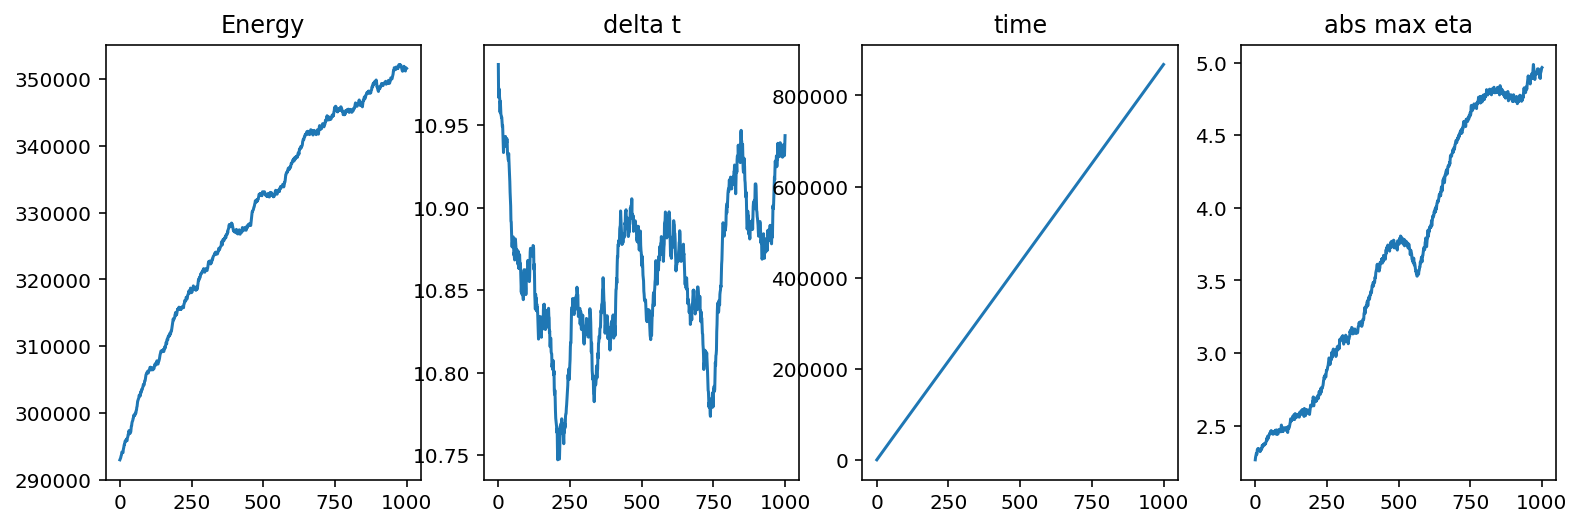

In [11]:

timesteps_axis = np.linspace(0, spin_up_timesteps, num=spin_up_timesteps)

fig = plt.figure(figsize=(13,4))
plt.subplot(1,4,1)
plt.plot(timesteps_axis, energy)
plt.title('Energy')
plt.subplot(1,4,2)
plt.plot(timesteps_axis, max_dt)
plt.title('delta t')
plt.subplot(1,4,3)
plt.plot(timesteps_axis, sim_time)
plt.title('time')
plt.subplot(1,4,4)
plt.plot(timesteps_axis, abs_max_eta)
plt.title("abs max eta")

print ("max dt: ", getEnergy(unpert_CDKLM)[1])

#eta, hu, hv = sim.download(interior_domain_only=True)
#fig = plt.figure()
#plotter = PlotHelper.PlotHelper(fig, x_coords, y_coords, radius, eta, hu, hv, interpolation_type="none")
#plt.suptitle('Time: ' + str(sim_time[-1]/(60*60)) + " hours")

## The standard perturbation case

step at i = 10
step at i = 20
step at i = 30
step at i = 40
step at i = 50
step at i = 60
step at i = 70
step at i = 80
step at i = 90
step at i = 100
step at i = 110
step at i = 120
step at i = 130
step at i = 140
step at i = 150
step at i = 160
step at i = 170
step at i = 180
step at i = 190
step at i = 200
step at i = 210
step at i = 220
step at i = 230
step at i = 240
step at i = 250
step at i = 260
step at i = 270
step at i = 280
step at i = 290
step at i = 300
step at i = 310
step at i = 320
step at i = 330
step at i = 340
step at i = 350
step at i = 360
step at i = 370
step at i = 380
step at i = 390
step at i = 400
step at i = 410
step at i = 420
step at i = 430
step at i = 440
step at i = 450
step at i = 460
step at i = 470
step at i = 480
step at i = 490
step at i = 500
step at i = 510
step at i = 520
step at i = 530
step at i = 540
step at i = 550
step at i = 560
step at i = 570
step at i = 580
step at i = 590
step at i = 600
step at i = 610
step at i = 620
step at i = 630
s

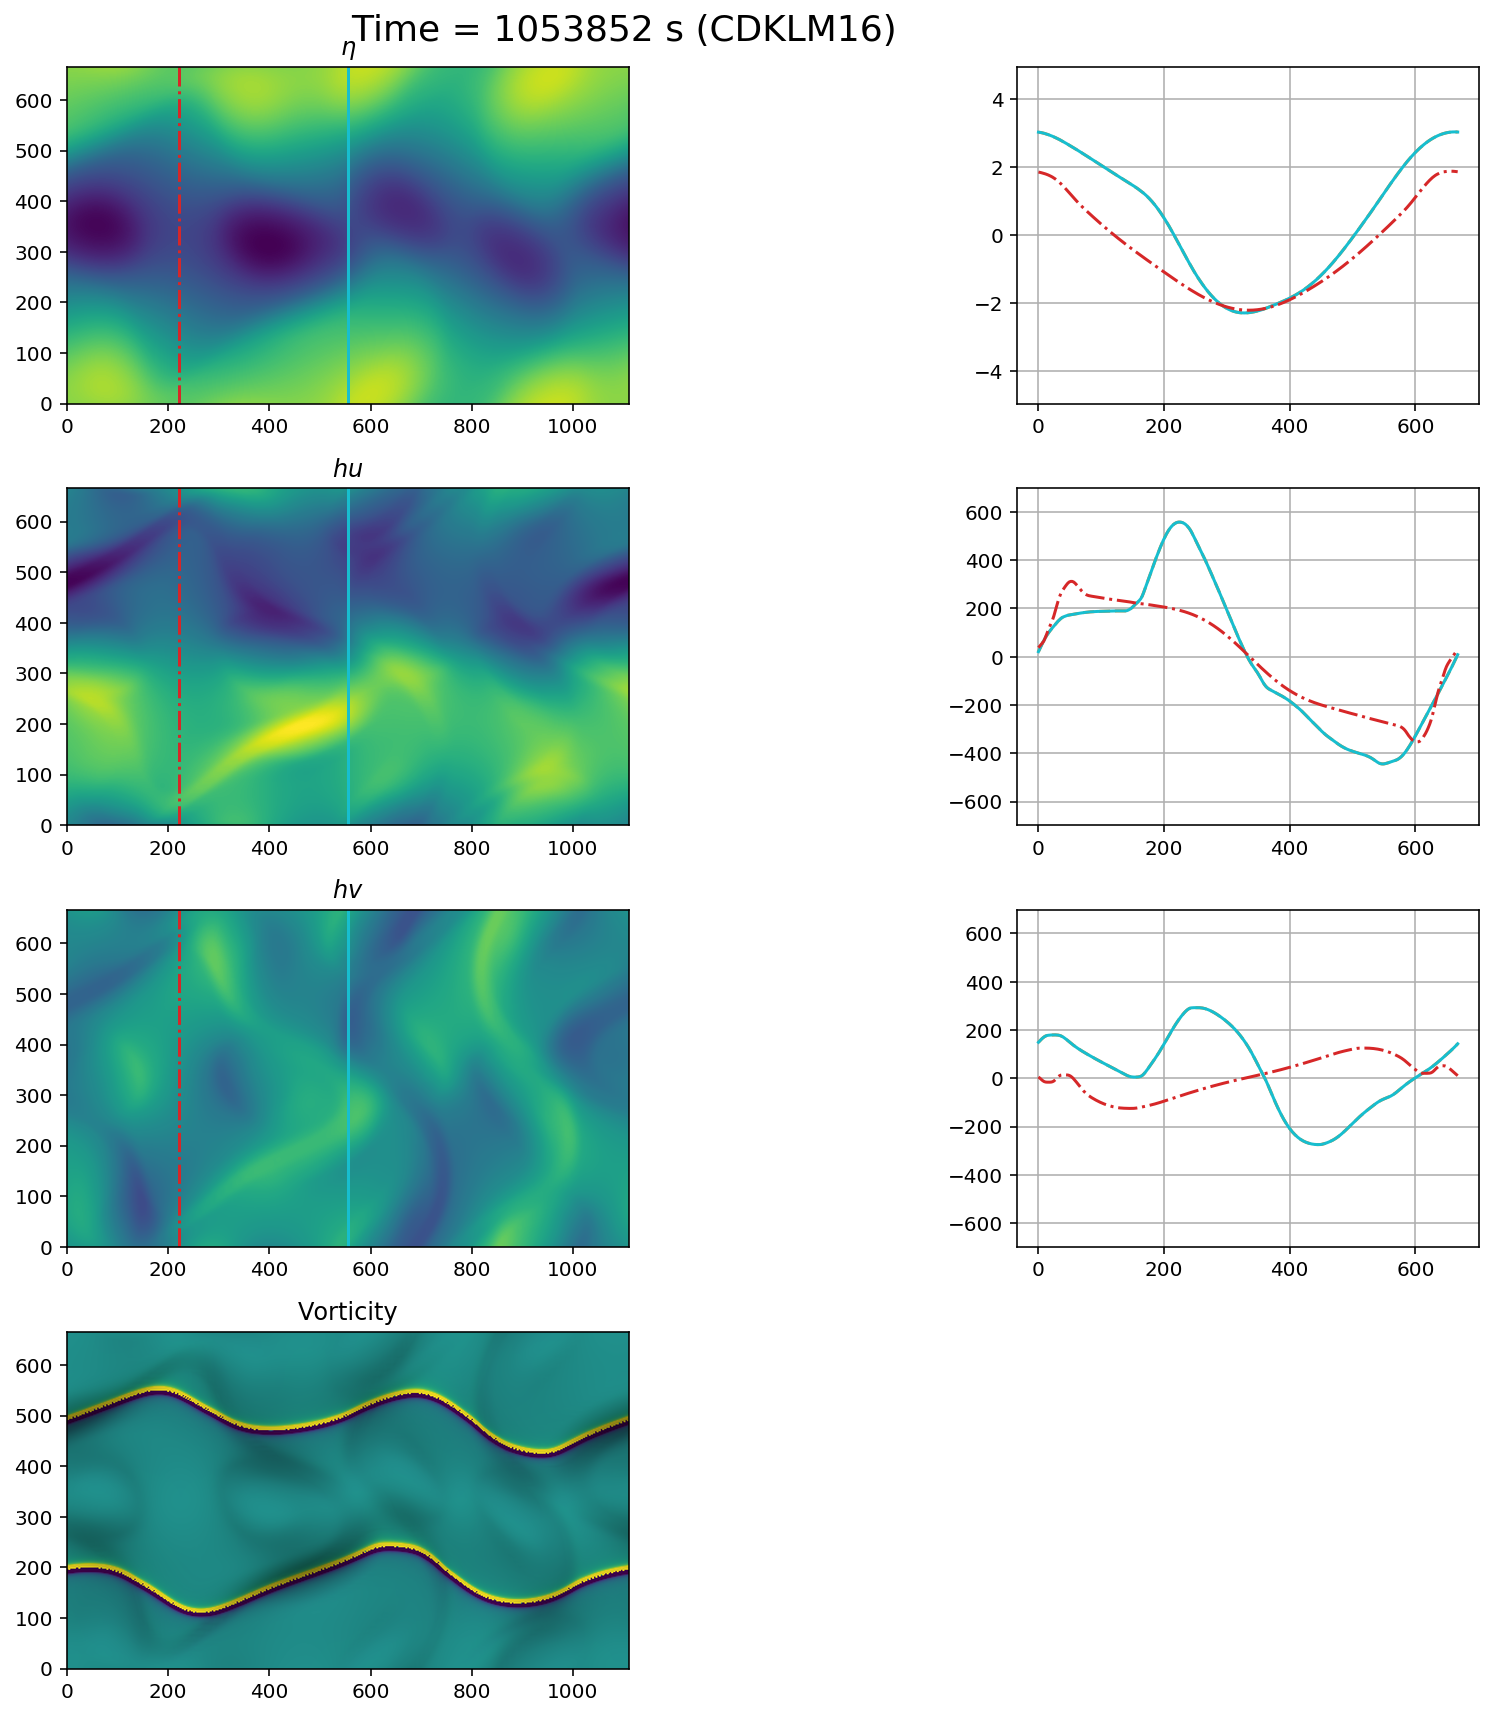

In [12]:
std_doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx,
                                                DoubleJetCase.DoubleJetPerturbationType.StandardPerturbedState,
                                                model_error=False)

std_args, std_init = std_doubleJetCase.getInitConditions()
std_CDKLM = CDKLM16.CDKLM16(**std_args, **std_init)

spin_up_timesteps = 1200
energy = np.zeros(spin_up_timesteps)
max_dt = np.zeros(spin_up_timesteps)
sim_time = np.zeros(spin_up_timesteps)
abs_max_eta = np.zeros(spin_up_timesteps)
energy[0], max_dt[0], abs_max_eta[0] = getEnergy(std_CDKLM)
sim_time[0] = 0.0

for i in range(1,spin_up_timesteps):
    step(i, std_CDKLM)

fig = sim_animation(std_CDKLM, None, None, crossection=True, snapshot=True)


max dt:  10.993762969970703


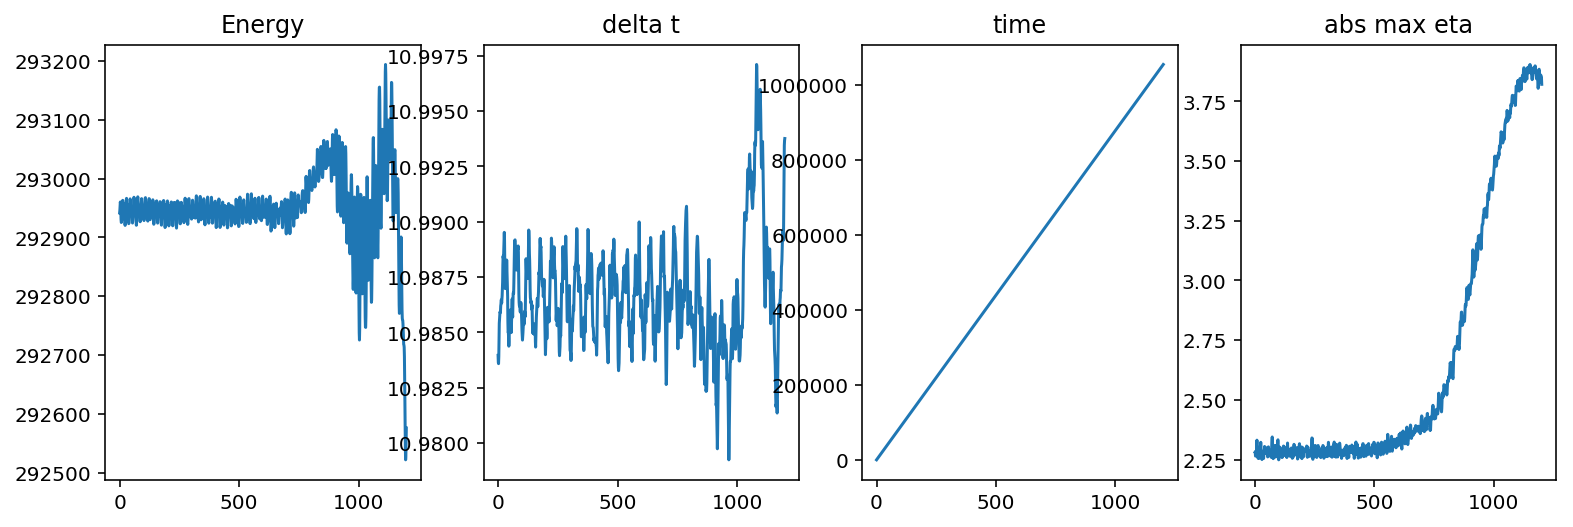

In [13]:

timesteps_axis = np.linspace(0, spin_up_timesteps, num=spin_up_timesteps)

fig = plt.figure(figsize=(13,4))
plt.subplot(1,4,1)
plt.plot(timesteps_axis, energy)
plt.title('Energy')
plt.subplot(1,4,2)
plt.plot(timesteps_axis, max_dt)
plt.title('delta t')
plt.subplot(1,4,3)
plt.plot(timesteps_axis, sim_time)
plt.title('time')
plt.subplot(1,4,4)
plt.plot(timesteps_axis, abs_max_eta)
plt.title("abs max eta")

print ("max dt: ", getEnergy(std_CDKLM)[1])

#eta, hu, hv = sim.download(interior_domain_only=True)
#fig = plt.figure()
#plotter = PlotHelper.PlotHelper(fig, x_coords, y_coords, radius, eta, hu, hv, interpolation_type="none")
#plt.suptitle('Time: ' + str(sim_time[-1]/(60*60)) + " hours")

Based on the above spin up state, we look at the typical change over each timestep.

In [28]:
def obtainStepStatistics(sim, model=True, q0_scale=1, num_timesteps=1):
    """
    Measures statistics of the size typical model step sizes or model error sizes.
    
    sim:    The simulator to measure, already spun up to the relevant time.
    model:  True if we want to meassure the size of the deterministic part only.
            False if we want to meassure the size of the model error only.
    
    """
    
    stats_timesteps = 100
    stats_energy = np.zeros(stats_timesteps+1)
    stats_max_dt = np.zeros(stats_timesteps+1)
    stats_sim_time = np.zeros(stats_timesteps+1)
    stats_abs_max_eta = np.zeros(stats_timesteps+1)
    all_eta = np.zeros((stats_timesteps, sim.ny, sim.nx))
    all_hu  = np.zeros((stats_timesteps, sim.ny, sim.nx))
    all_hv  = np.zeros((stats_timesteps, sim.ny, sim.nx))
    stats_energy[0], stats_max_dt[0], stats_abs_max_eta[0] = getEnergy(sim)
    stats_sim_time[0] = 0.0
    
    eta, hu, hv = sim.download(interior_domain_only=True)
    prev_eta, prev_hu, prev_hv = sim.download(interior_domain_only=True)

    t = 0
    for i in range(stats_timesteps):
        
        if model:
            t = sim.step(num_timesteps*sim.dt, apply_stochastic_term=False)
        else:
            sim.perturbState(q0_scale=q0_scale)
            t += 1
            
        eta, hu, hv = sim.download(interior_domain_only=True)
        all_eta[i,:,:] = prev_eta - eta
        all_hu[i,:,:]  = prev_hu  - hu
        all_hv[i,:,:]  = prev_hv  - hv

        prev_eta, prev_hu, prev_hv = eta.copy(), hu.copy(), hv.copy()

        stats_sim_time[i+1] = t
        stats_energy[i+1], stats_max_dt[i+1], stats_abs_max_eta[i+1] = getEnergy(sim)
        print("."+str(i)+".", end='')
        #sim.dt = 0.8*stats_max_dt[i+1]
    
    stats_timesteps_axis = np.linspace(0, stats_timesteps+1, num=stats_timesteps+1)

    fig = plt.figure(figsize=(13,4))
    plt.subplot(1,4,1)
    plt.plot(stats_timesteps_axis, stats_energy)
    plt.title('Energy')
    plt.subplot(1,4,2)
    plt.plot(stats_timesteps_axis, stats_max_dt)
    plt.title('delta t')
    plt.subplot(1,4,3)
    plt.plot(stats_timesteps_axis, stats_sim_time)
    plt.title('time')
    plt.subplot(1,4,4)
    plt.plot(stats_timesteps_axis, stats_abs_max_eta)
    plt.title("abs max eta")
    
    print ("all_eta.mean(), all_hu.mean(), all_hv.mean()")
    print (all_eta.mean(), all_hu.mean(), all_hv.mean())
    print ("all_eta.var(),  all_hu.var() , all_hv.var()")
    print (all_eta.var(),  all_hu.var() , all_hv.var())
    print ("np.abs(all_eta).mean(), np.abs(all_hu).mean(), np.abs(all_hv).mean()")
    print (np.abs(all_eta).mean(), np.abs(all_hu).mean(), np.abs(all_hv).mean())
    print ("np.abs(all_eta).var(), np.abs(all_hu).var(), np.abs(all_hv).var()")
    print (np.abs(all_eta).var(), np.abs(all_hu).var(), np.abs(all_hv).var())
    
    fig = sim_animation(sim, None, None, crossection=True, snapshot=True)

.0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79..80..81..82..83..84..85..86..87..88..89..90..91..92..93..94..95..96..97..98..99.all_eta.mean(), all_hu.mean(), all_hv.mean()
1.7666417140086803e-11 -0.001767399593519008 -0.0015096758794927814
all_eta.var(),  all_hu.var() , all_hv.var()
3.267807756595938e-08 0.00020141853922526833 0.0004357129345022431
np.abs(all_eta).mean(), np.abs(all_hu).mean(), np.abs(all_hv).mean()
0.00014722550948466525 0.010813701324897748 0.015753592071662333
np.abs(all_eta).var(), np.abs(all_hu).var(), np.abs(all_hv).var()
1.1002726922940476e-08 8.760610420434382e-05 0.00018981639260302308
sim.download in sim_animator - eta1.shape:  (300, 500)


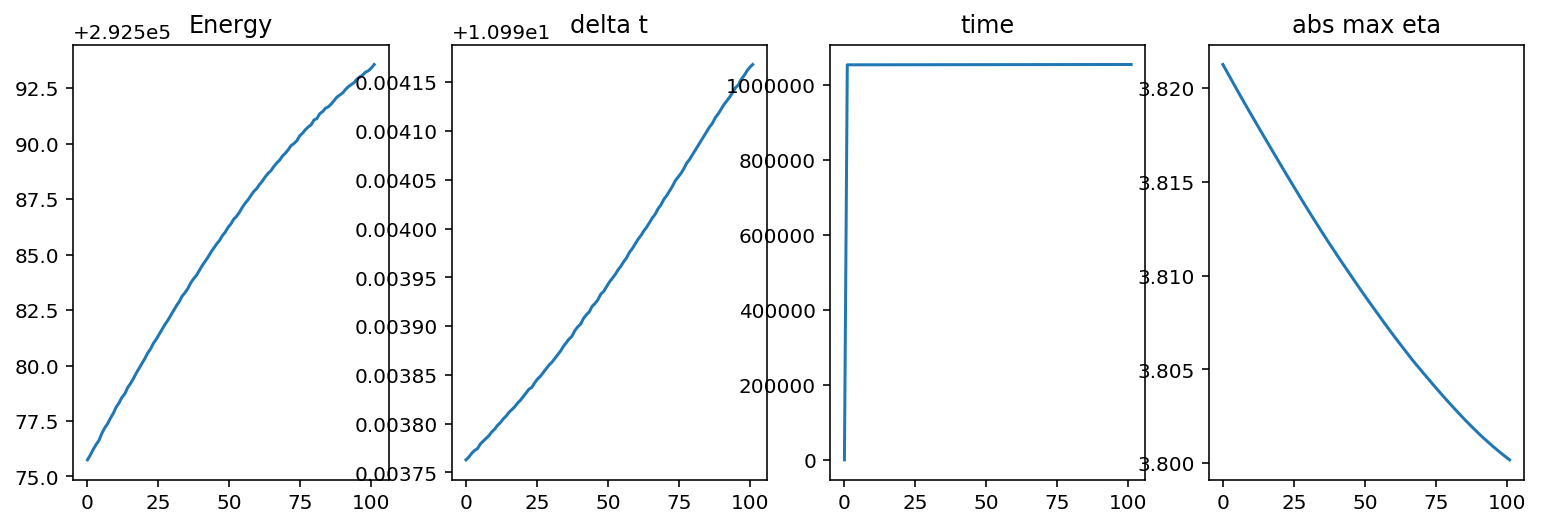

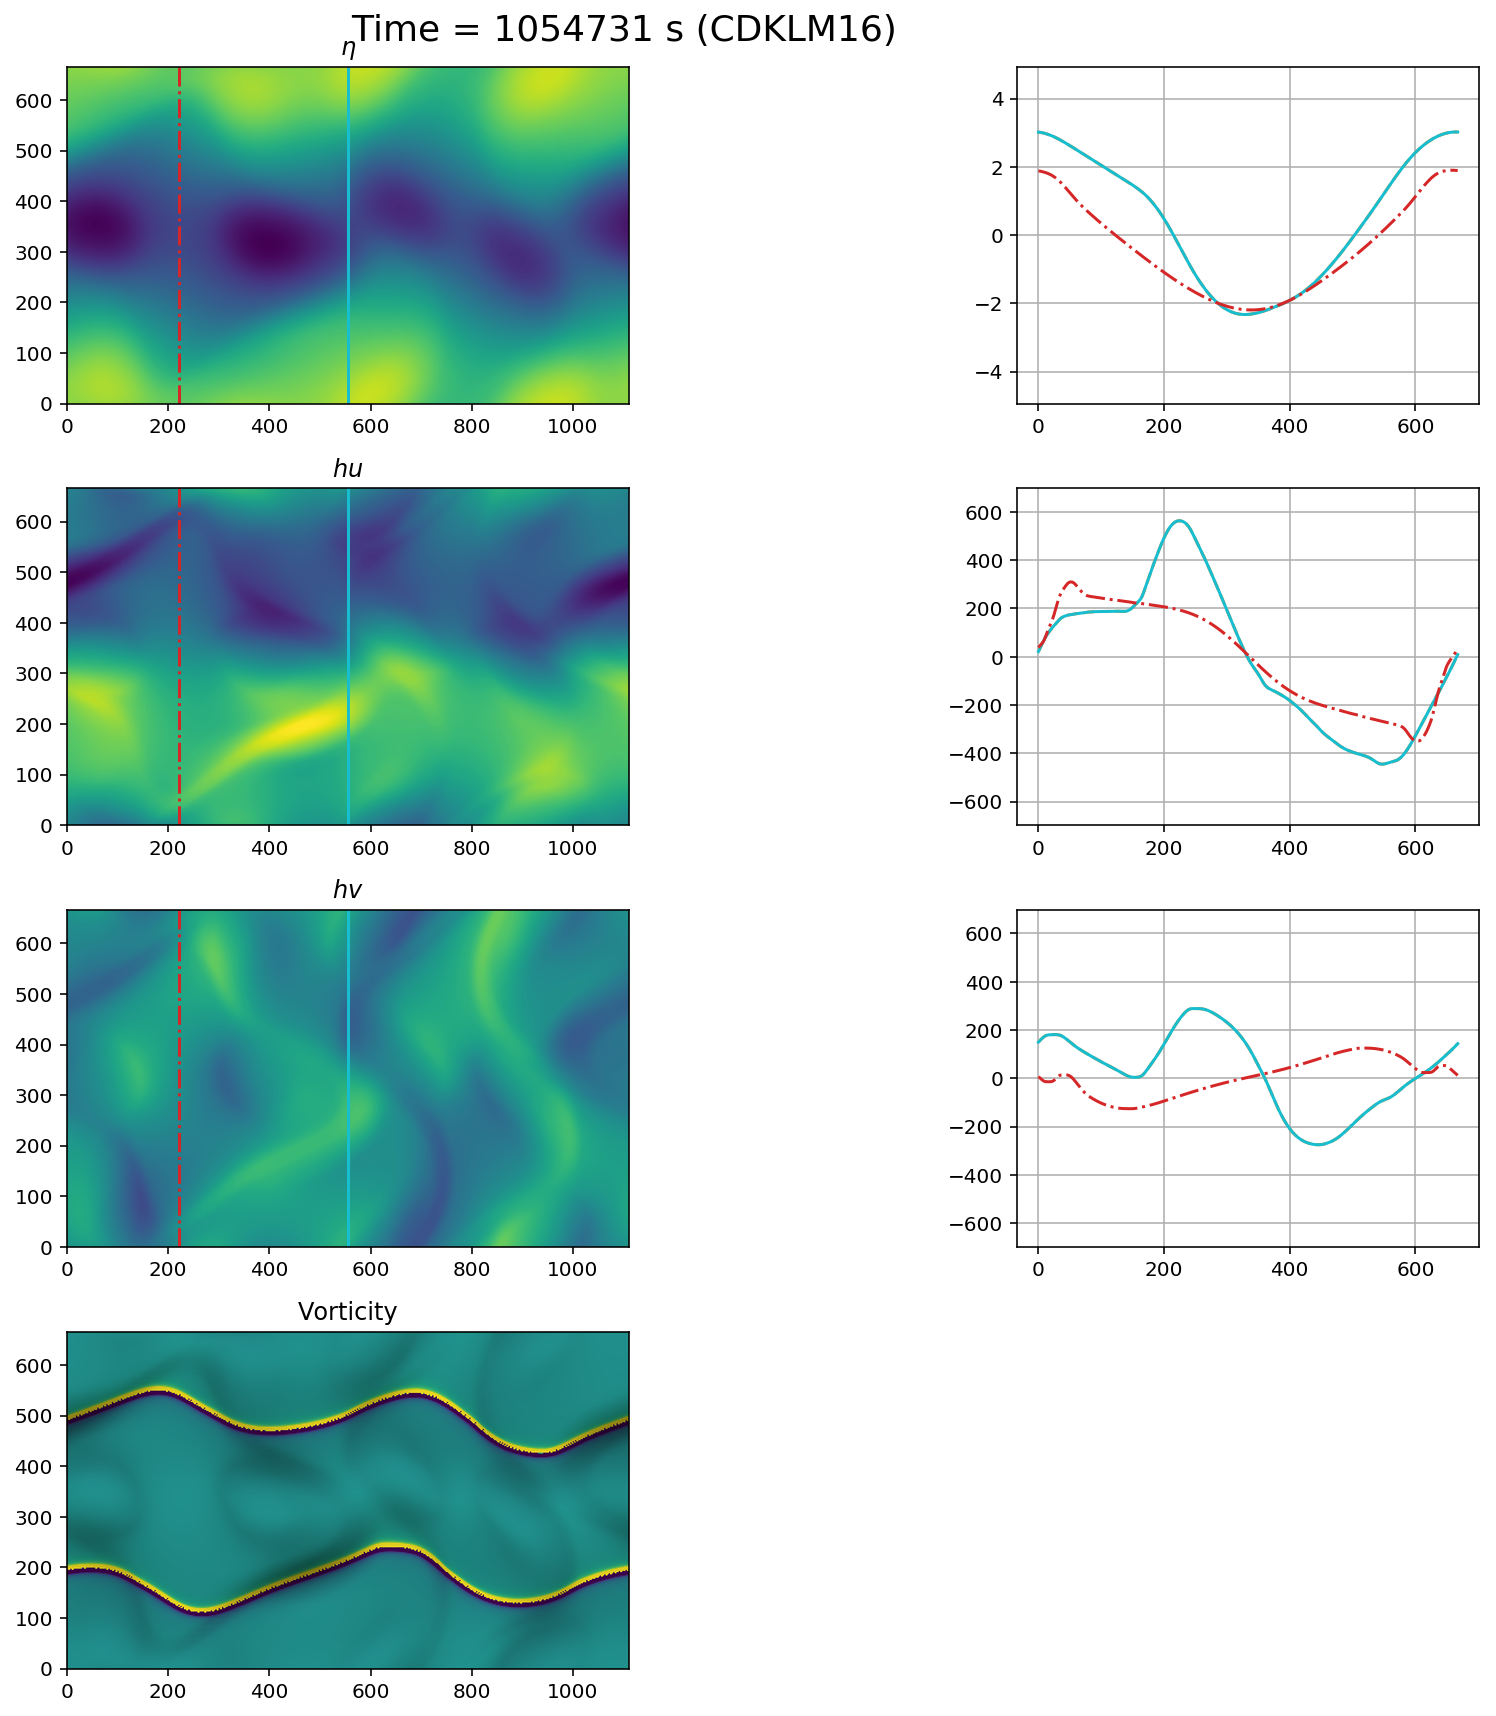

In [15]:
# Standard case:
obtainStepStatistics(std_CDKLM)

.0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79..80..81..82..83..84..85..86..87..88..89..90..91..92..93..94..95..96..97..98..99.all_eta.mean(), all_hu.mean(), all_hv.mean()
3.1729487559156648e-09 -0.01018135647707982 -0.01917864637673668
all_eta.var(),  all_hu.var() , all_hv.var()
8.631435742572442e-06 0.3157399296673781 0.2499346172212382
np.abs(all_eta).mean(), np.abs(all_hu).mean(), np.abs(all_hv).mean()
0.002339592858634189 0.4052121477409279 0.3668214787502915
np.abs(all_eta).var(), np.abs(all_hu).var(), np.abs(all_hv).var()
3.1577409984104037e-06 0.15164670501027672 0.11574444042553186
sim.download in sim_animator - eta1.shape:  (300, 500)


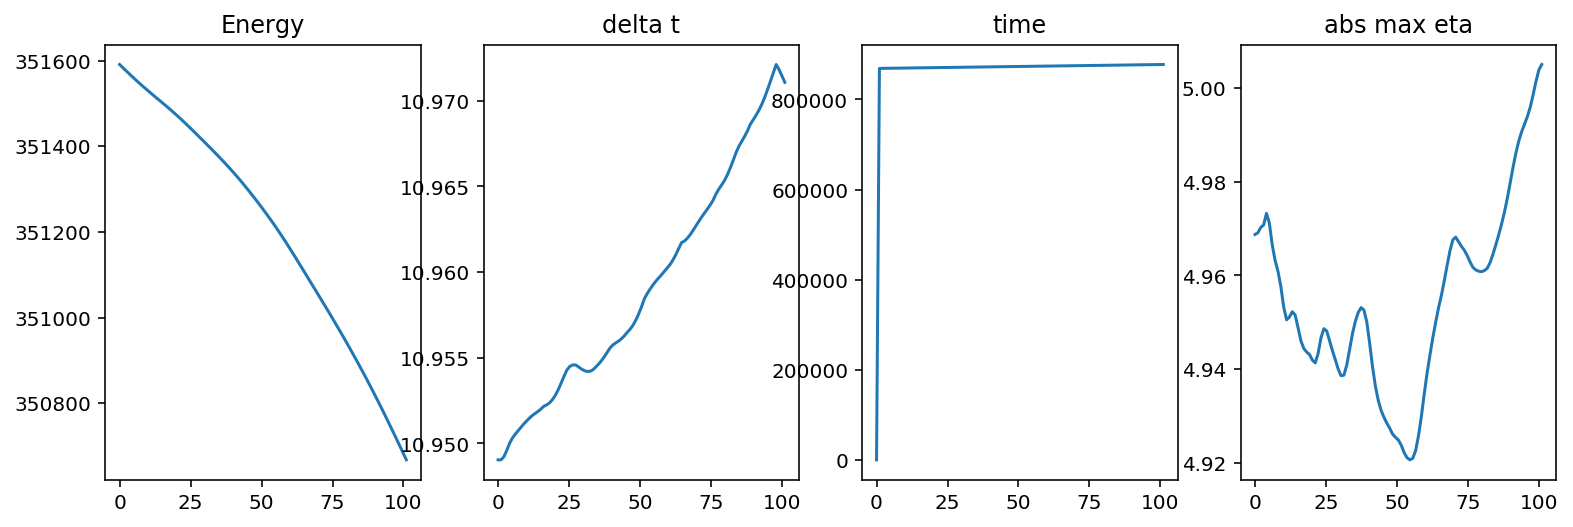

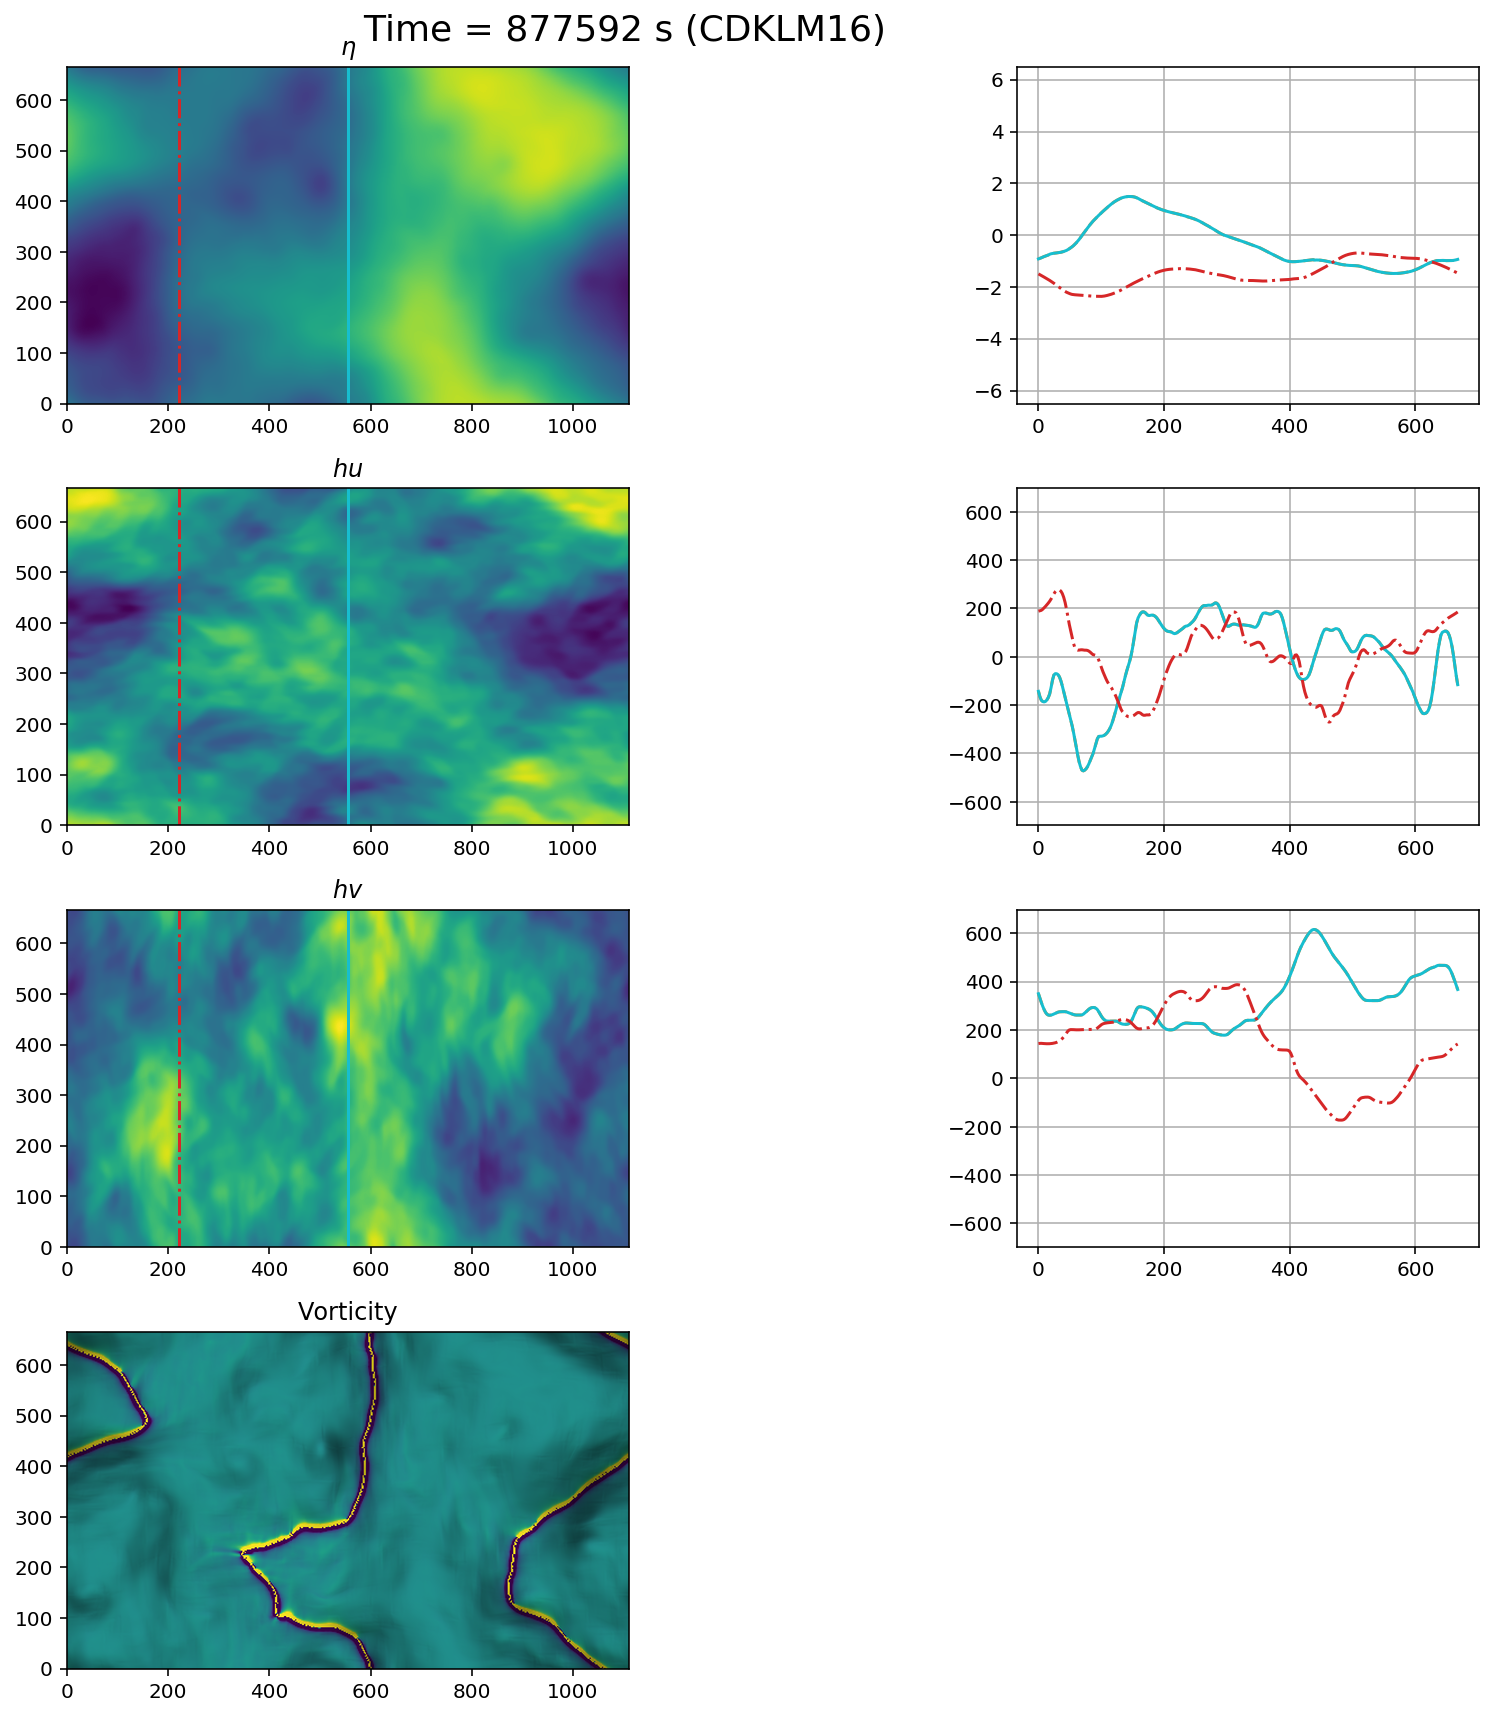

In [29]:
# Assumed best case:
obtainStepStatistics(unpert_CDKLM, num_timesteps=10)

.0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79..80..81..82..83..84..85..86..87..88..89..90..91..92..93..94..95..96..97..98..99.all_eta.mean(), all_hu.mean(), all_hv.mean()
6.097058455149333e-11 0.00125839813251514 -0.0019775274800136683
all_eta.var(),  all_hu.var() , all_hv.var()
1.008157860475481e-08 1.3321531344841763e-06 1.8273998714455265e-05
np.abs(all_eta).mean(), np.abs(all_hu).mean(), np.abs(all_hv).mean()
8.669213093817234e-05 0.0013095353354932741 0.003805571026712035
np.abs(all_eta).var(), np.abs(all_hu).var(), np.abs(all_hv).var()
2.566053038157309e-09 1.2008361994962899e-06 7.702242809314386e-06
sim.download in sim_animator - eta1.shape:  (300, 500)


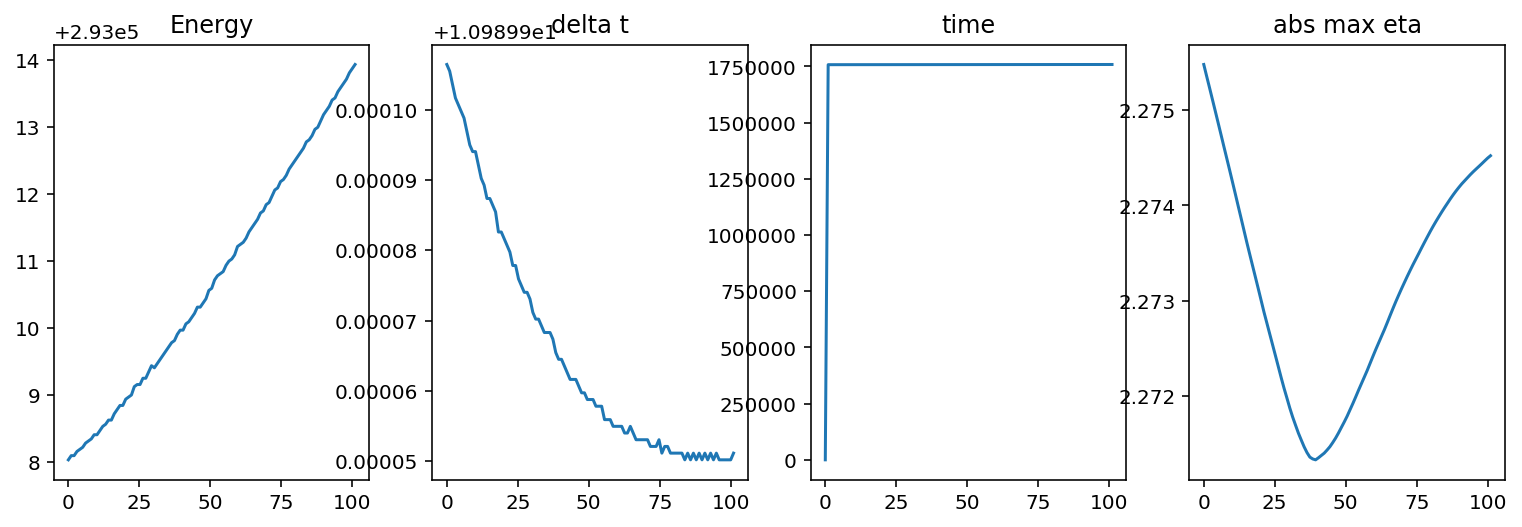

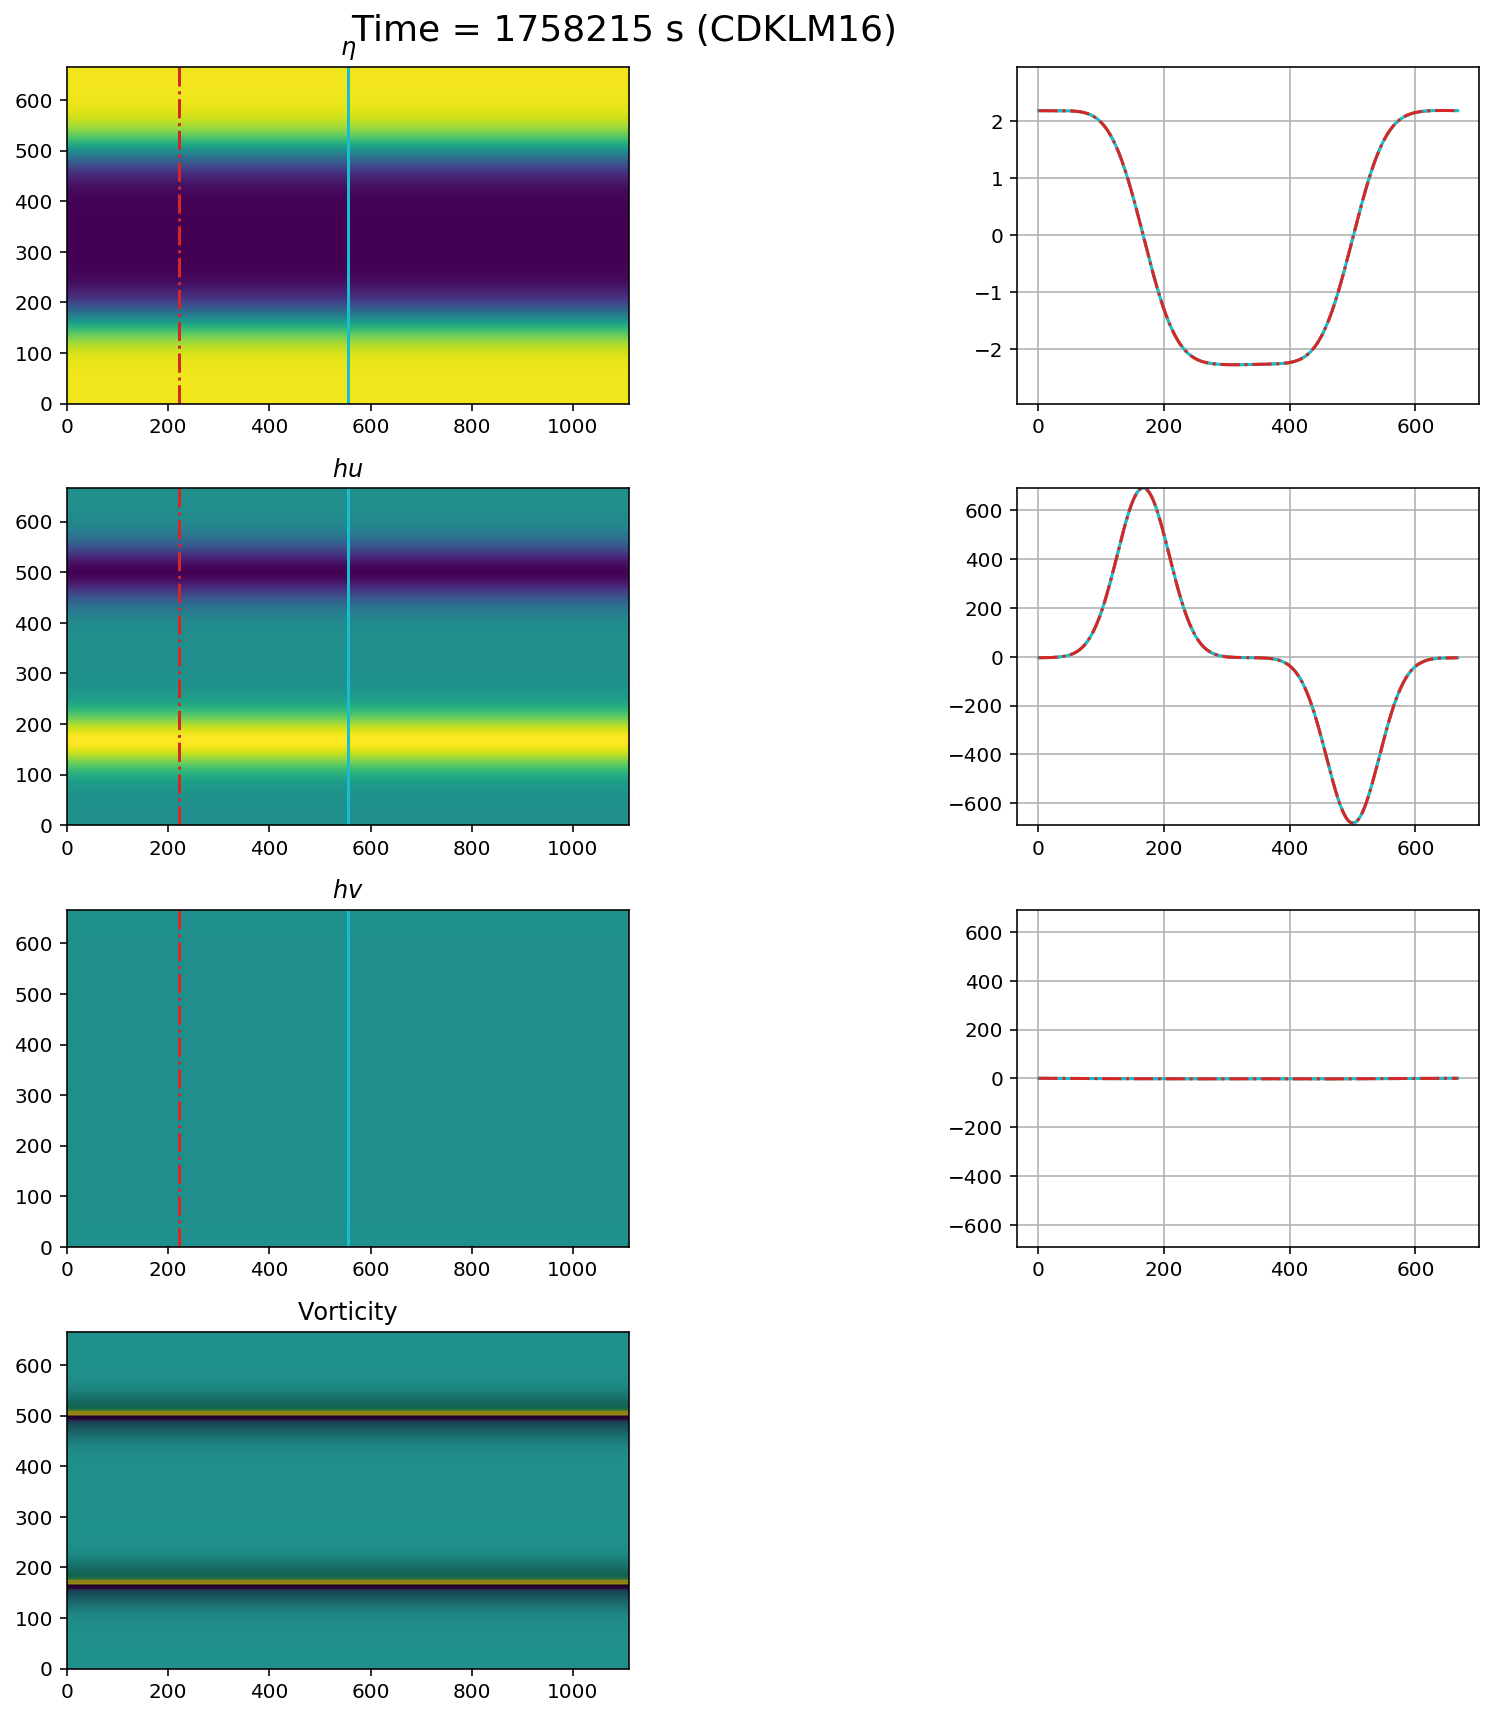

In [17]:
# Steady state case:
obtainStepStatistics(steadystate_CDKLM)

## How do we chose the size of the model error?

The state $x$ evolves (more or less) according to 
$$ x^{n+1} = x^n + f(x^n)\Delta t + \Delta \beta,$$
in which $f$ is the determinstic numerical scheme, and $\Delta \beta$ is the stochastic model error.

Above, we have meassured the mean of the term $f(x^n)\Delta t$. Below we meassure the mean of model error $\Delta \beta$ in a similar way


.0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79..80..81..82..83..84..85..86..87..88..89..90..91..92..93..94..95..96..97..98..99.all_eta.mean(), all_hu.mean(), all_hv.mean()
1.4083401050659934e-09 -1.2883499342327317e-09 7.609549521779021e-10
all_eta.var(),  all_hu.var() , all_hv.var()
2.160488566219205e-08 0.015298642385186566 0.015099966402334172
np.abs(all_eta).mean(), np.abs(all_hu).mean(), np.abs(all_hv).mean()
0.00011729195818989396 0.09852275469425224 0.09787987105507479
np.abs(all_eta).var(), np.abs(all_hu).var(), np.abs(all_hv).var()
7.847482208155652e-09 0.005591909192642784 0.005519497244576103
sim.download in sim_animator - eta1.shape:  (300, 500)


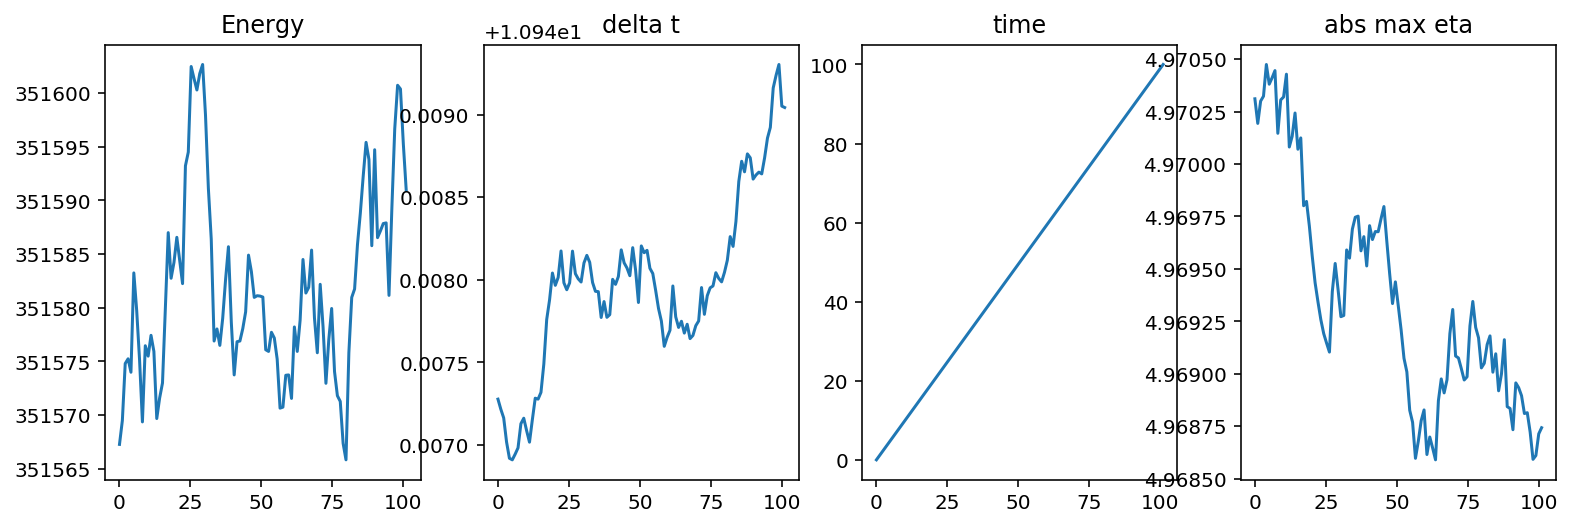

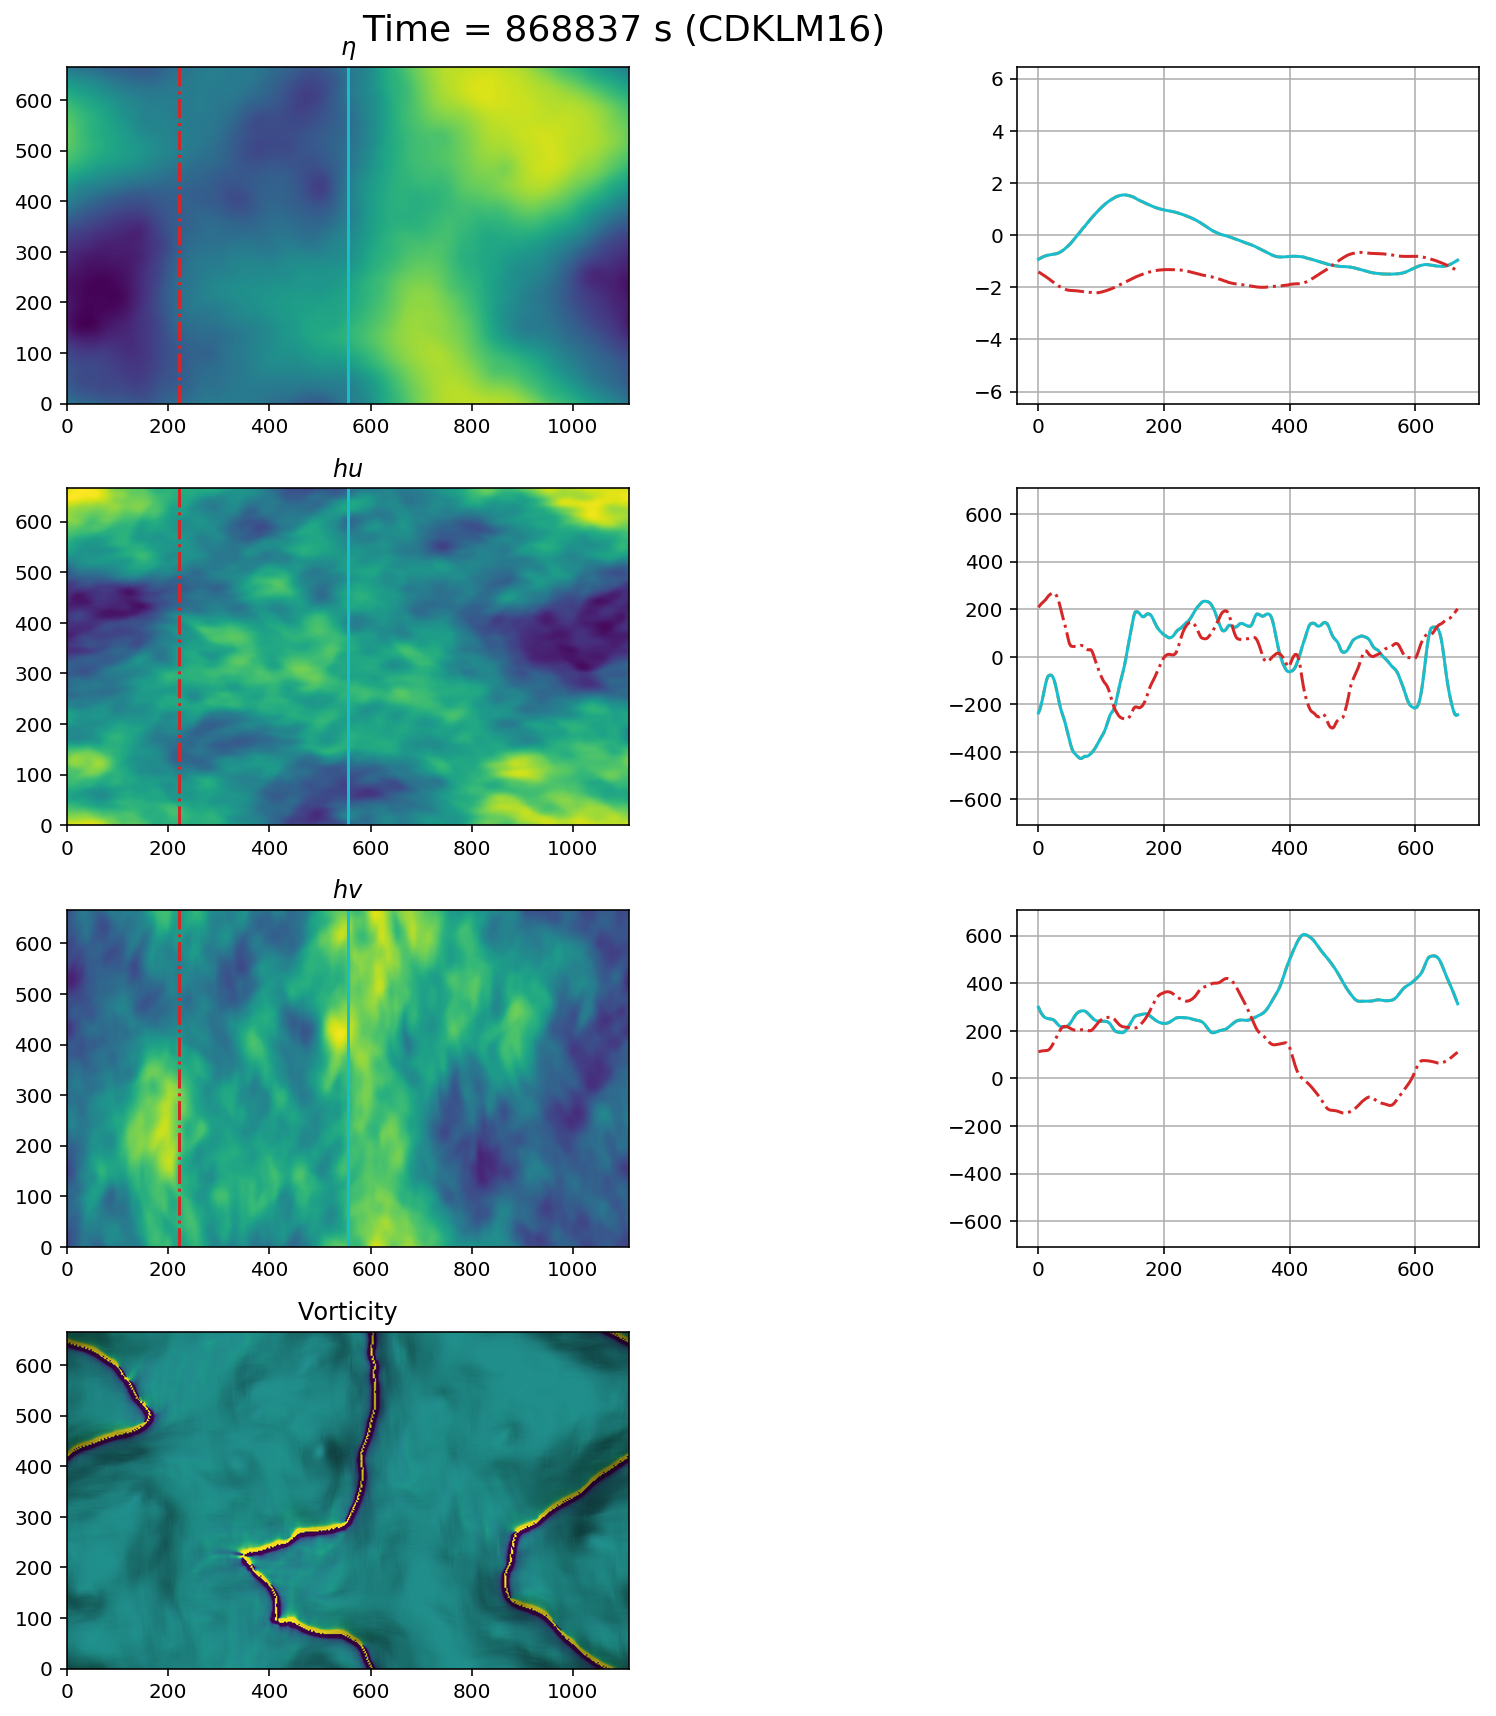

In [27]:
# Assumed best case:
obtainStepStatistics(unpert_CDKLM, model=False, q0_scale=0.25)

# Looking at the model error isolated

In [64]:
oceannoise_doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx,  
                                                       model_error=True)
oceannoise_args, oceannoise_init = oceannoise_doubleJetCase.getInitConditions()
oceannoise_args['small_scale_perturbation_interpolation_factor'] = 1
print(oceannoise_args)
oceannoise_CDKLM = CDKLM16.CDKLM16(**oceannoise_args, **oceannoise_init)

{'gpu_ctx': <SWESimulators.Common.CUDAContext object at 0x7f5f6027f630>, 'nx': 500, 'ny': 300, 'dx': 2220.0, 'dy': 2220.0, 'dt': 8.824505883716155, 'g': 9.80616, 'f': 0.00014087062250599773, 'coriolis_beta': 0.0, 'r': 0.0, 'H': array([[227.77013, 227.77013, 227.77013, ..., 227.77013, 227.77013,
        227.77013],
       [227.77013, 227.77013, 227.77013, ..., 227.77013, 227.77013,
        227.77013],
       [227.77013, 227.77013, 227.77013, ..., 227.77013, 227.77013,
        227.77013],
       ...,
       [227.77013, 227.77013, 227.77013, ..., 227.77013, 227.77013,
        227.77013],
       [227.77013, 227.77013, 227.77013, ..., 227.77013, 227.77013,
        227.77013],
       [227.77013, 227.77013, 227.77013, ..., 227.77013, 227.77013,
        227.77013]], dtype=float32), 'rk_order': 2, 'boundary_conditions': <SWESimulators.Common.BoundaryConditions object at 0x7f5f04dca048>, 'small_scale_perturbation': True, 'small_scale_perturbation_amplitude': 0.0003, 'small_scale_perturbation_int

In [65]:
boundary = True
eta_pre, hu_pre, hv_pre = oceannoise_CDKLM.download(interior_domain_only=boundary)
oceannoise_CDKLM.perturbState()
eta_post, hu_post, hv_post = oceannoise_CDKLM.download(interior_domain_only=boundary)
eta_diff = eta_post - eta_pre

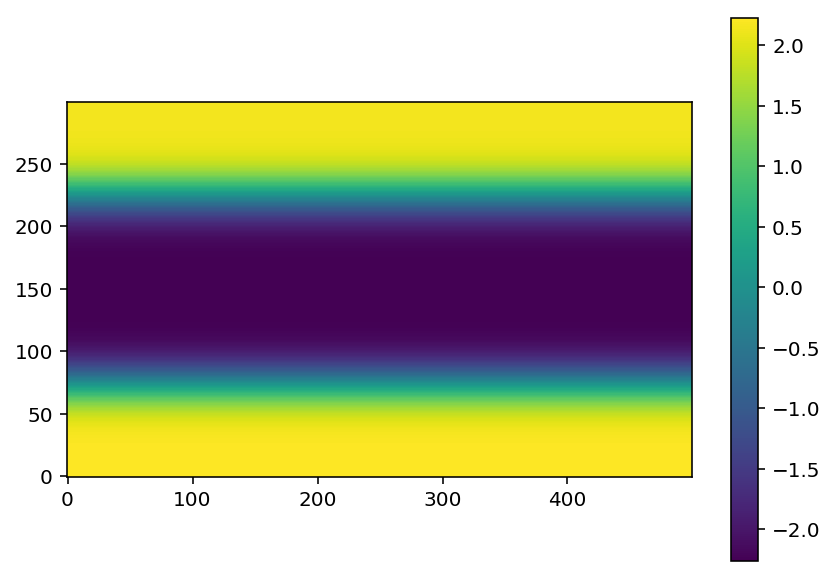

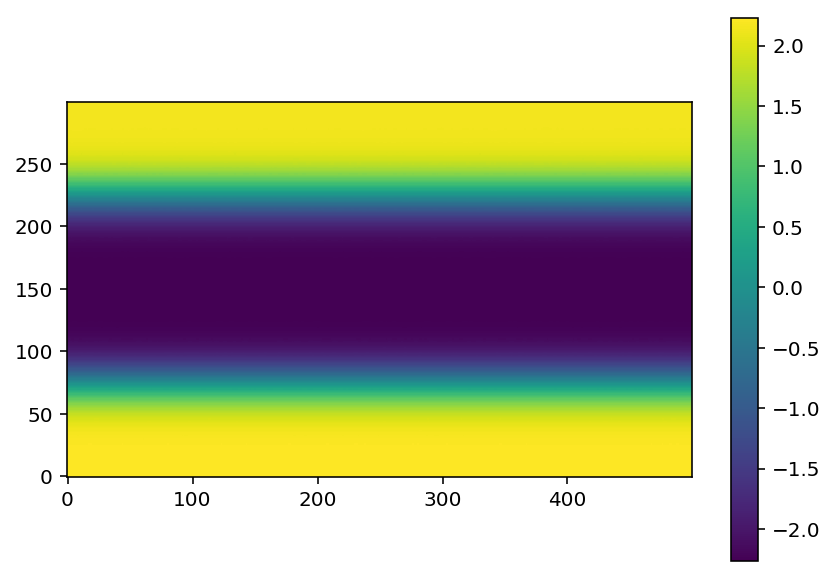

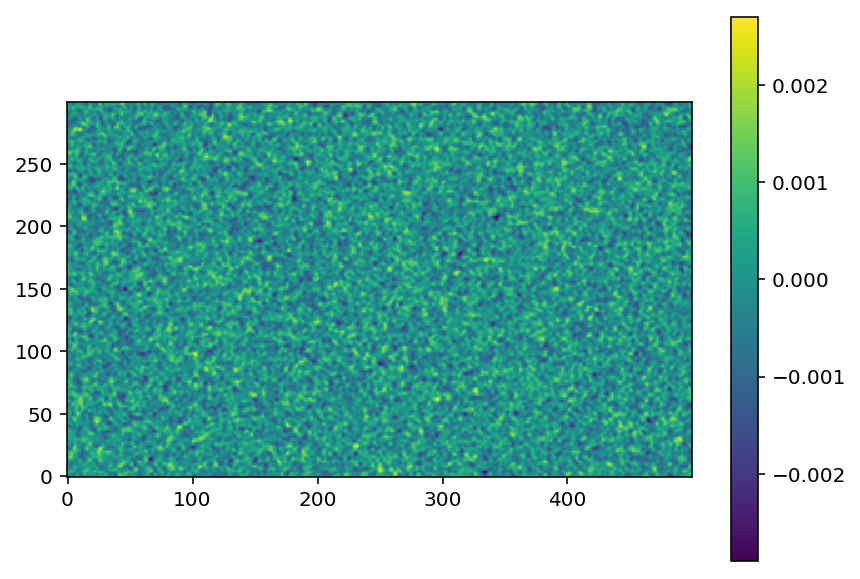

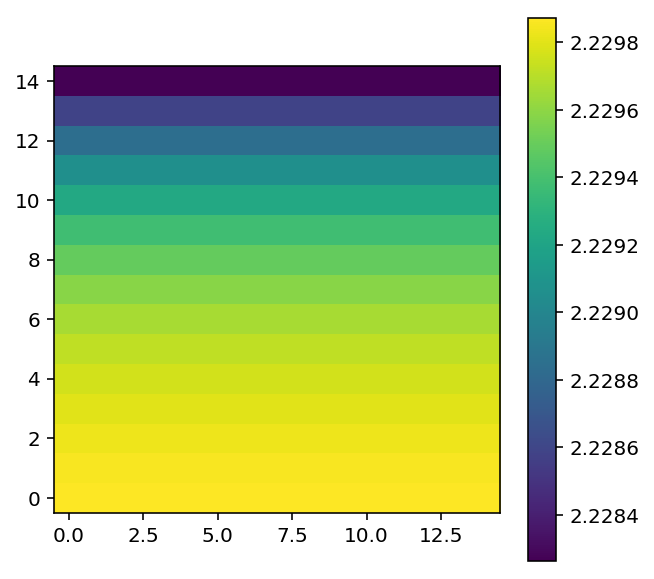

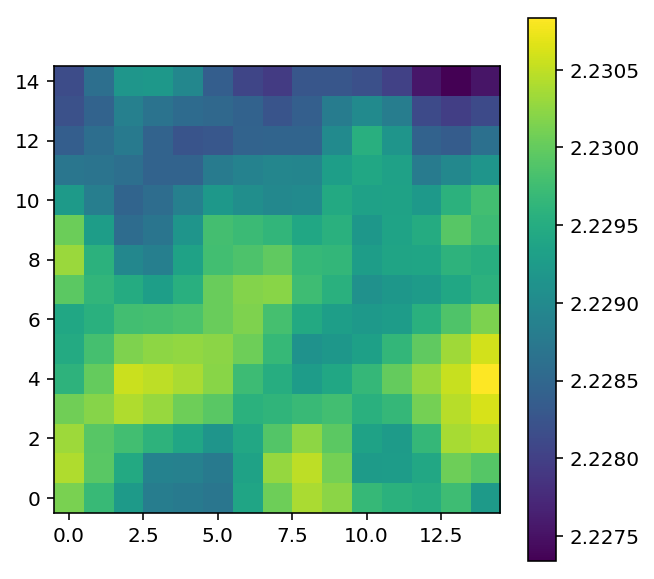

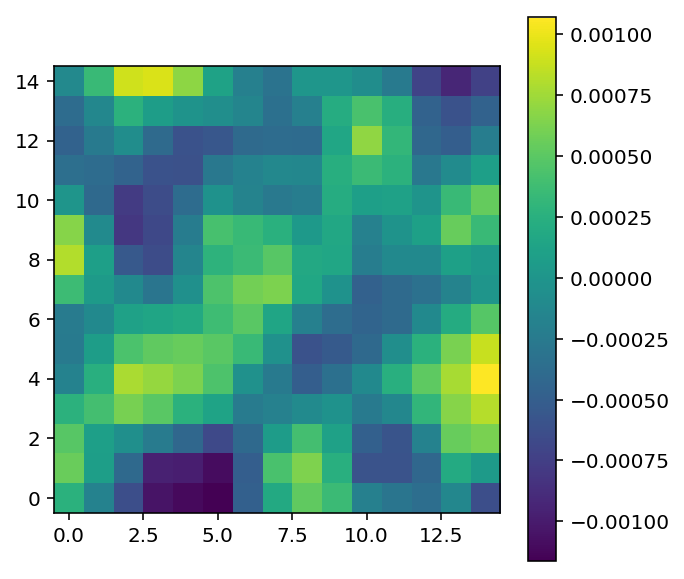

In [66]:
def imshow(data):
    fig = plt.figure(figsize=(7,5))
    plt.imshow(data, origin='lower', interpolation='None')
    plt.colorbar()
    
def zoom_imshow(data):
    fig = plt.figure(figsize=(5,5))
    plt.imshow(data[:15, :15], origin='lower', interpolation='None')
    plt.colorbar()
    

imshow(eta_pre)
imshow(eta_post)
imshow(eta_diff)

zoom_imshow(eta_pre)
zoom_imshow(eta_post)
zoom_imshow(eta_diff)

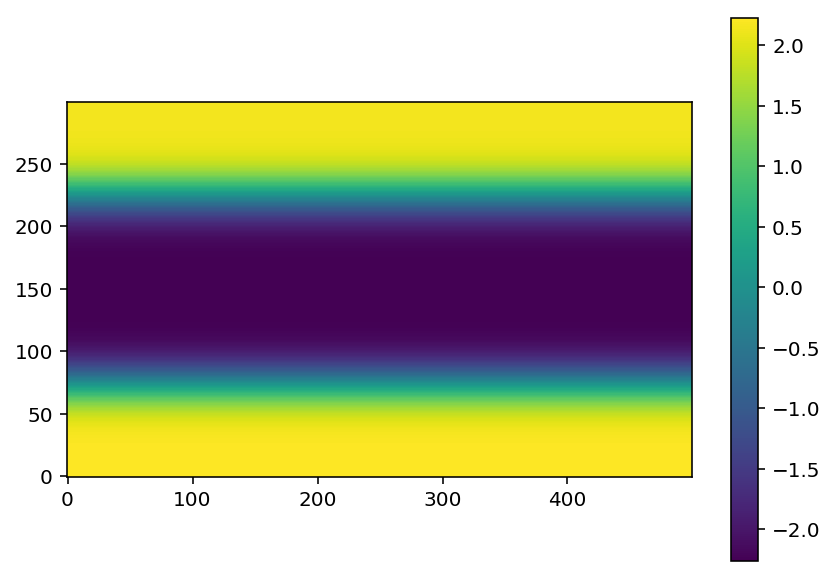

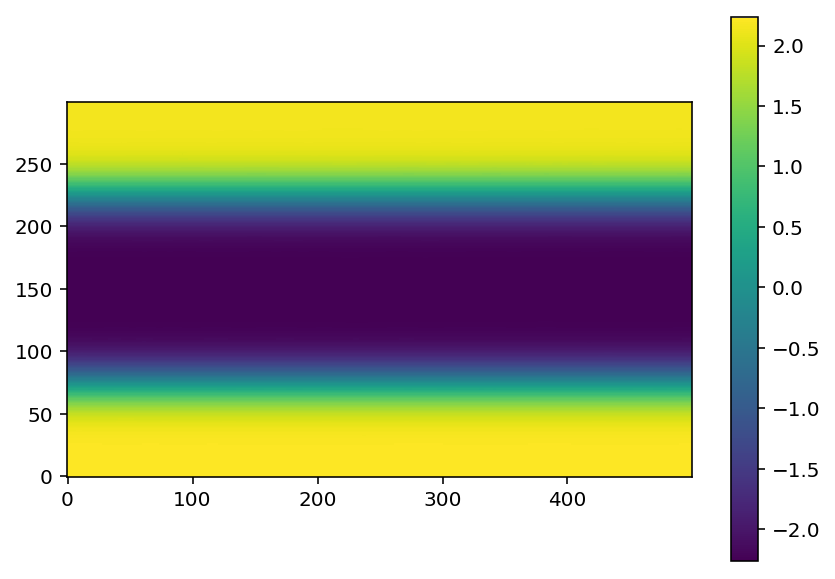

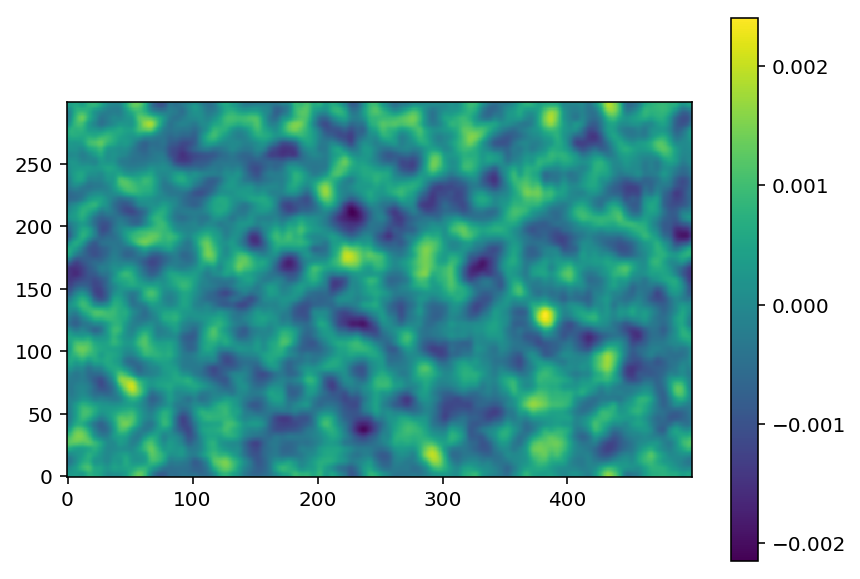

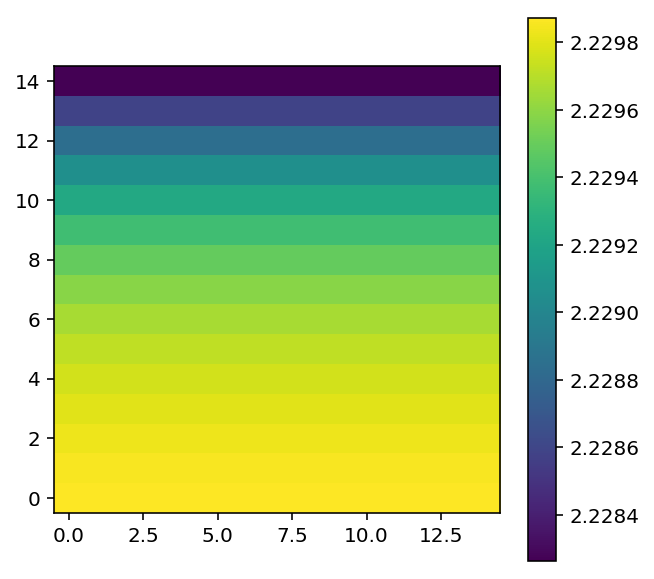

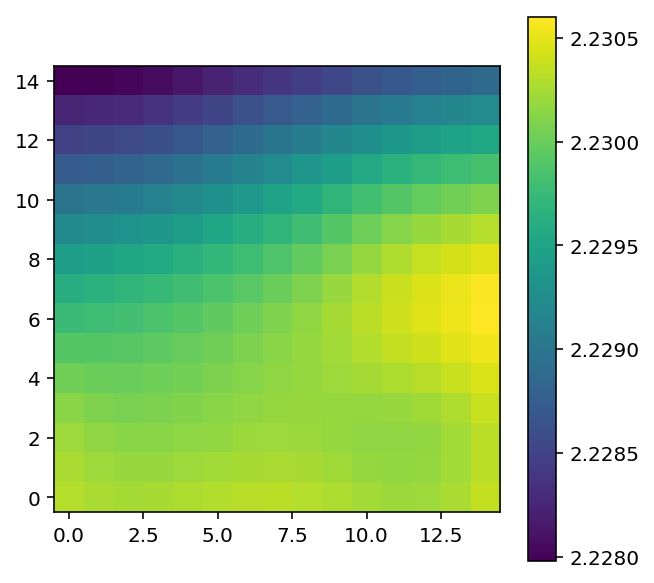

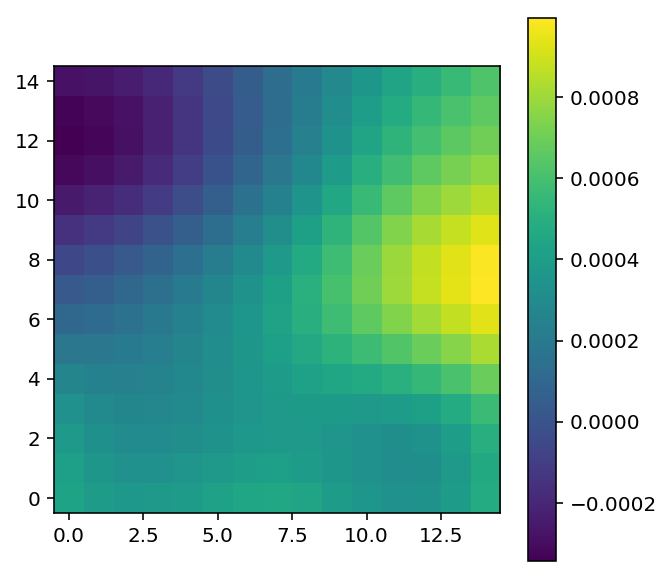

In [60]:
def imshow(data):
    fig = plt.figure(figsize=(7,5))
    plt.imshow(data, origin='lower', interpolation='None')
    plt.colorbar()
    
def zoom_imshow(data):
    fig = plt.figure(figsize=(5,5))
    plt.imshow(data[:15, :15], origin='lower', interpolation='None')
    plt.colorbar()
    

imshow(eta_pre)
imshow(eta_post)
imshow(eta_diff)

zoom_imshow(eta_pre)
zoom_imshow(eta_post)
zoom_imshow(eta_diff)

In [46]:
print(eta_diff.shape)

(300, 500)


In [67]:
print(eta_diff[0,0])
print(eta_diff[0,-1])

0.00026512146
0.00048327446
